In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:

configs.data_name = data_name



In [7]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [8]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [9]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [10]:
data_name

'dd_fix_stats_demo'

In [11]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [12]:


data_name



'dd_fix_stats_demo'

In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,8,645.693750,283.247212,537.731250,5.683393,147.500000,78.438086,1,4,10,23,102.0
1,1,10,5,8,644.781081,202.020928,524.345946,8.486152,180.810811,88.588574,1,4,10,23,102.0
2,1,10,6,9,708.334615,292.435973,536.546154,7.099140,187.961538,130.054290,1,4,10,23,102.0
3,1,10,7,8,676.047619,317.074279,535.933333,6.465627,179.761905,73.502996,1,4,10,23,102.0
4,1,10,8,8,440.215000,235.935556,541.580000,5.290667,201.800000,91.100638,1,4,10,23,102.0


In [14]:
df_data_to_use.shape

(9071, 15)

In [15]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [16]:

x_org.head()



,Grade_3,Sex_1,Grade_2,FIX_DURATION_mean,Grade_4,Grade_6,Word_Number,FIX_Y_mean,FIX_Y_std,FIX_DURATION_std,Grade_1,IQ,Age,FIX_X_mean,FIX_X_std,Sex_2,Grade_5
0,0,1,0,147.500000,1,0,8,537.731250,5.683393,78.438086,0,23,10,645.693750,283.247212,0,0
1,0,1,0,180.810811,1,0,8,524.345946,8.486152,88.588574,0,23,10,644.781081,202.020928,0,0
2,0,1,0,187.961538,1,0,9,536.546154,7.099140,130.054290,0,23,10,708.334615,292.435973,0,0
3,0,1,0,179.761905,1,0,8,535.933333,6.465627,73.502996,0,23,10,676.047619,317.074279,0,0
4,0,1,0,201.800000,1,0,8,541.580000,5.290667,91.100638,0,23,10,440.215000,235.935556,0,0


In [17]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [18]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [19]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [20]:
x.shape

(9071, 17)

In [21]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=2
    )



In [22]:

data


defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.   , 1.   , 0.   , ..., 0.401, 0.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.283, 0.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.445, 0.   , 0.   ],
                                 ...,
                                 [1.   , 0.   , 0.   , ..., 0.391, 1.   , 0.   ],
                                 [1.   , 0.   , 0.   , ..., 0.367, 1.   , 0.   ],
                                 [1.   , 0.   , 0.   , ..., 0.404, 1.   , 0.   ]]),
                          'x_test': array([[0.   , 1.   , 0.   , ..., 0.414, 0.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.45 , 0.   , 0.   ],
                                 [0.   , 1.   , 0.   , ..., 0.332, 0.   , 0.   ],
                                 ...,
                                 [1.   , 0.   , 0.   , ..., 0.521, 1.   , 0.   ],
        

## Load the tuned parameters

In [23]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [24]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [25]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [26]:

n_s = str(2)
x_train = data[n_s]["x_train"]
x_test = data[n_s]["x_test"]
y_train = data[n_s]["y_train"]
y_test = data[n_s]["y_test"]



In [27]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

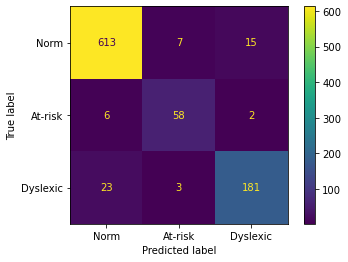

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


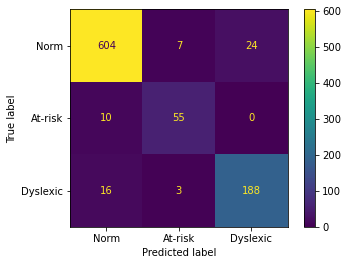

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


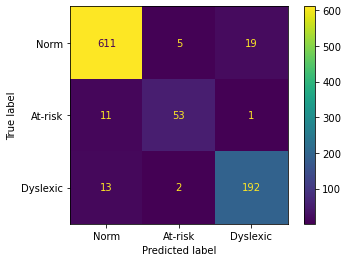

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


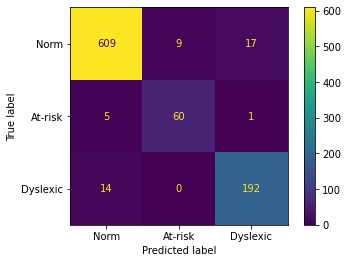

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


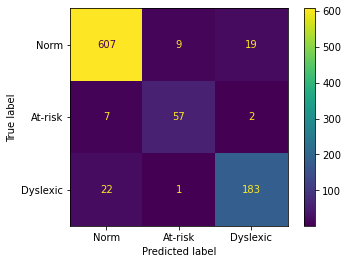

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


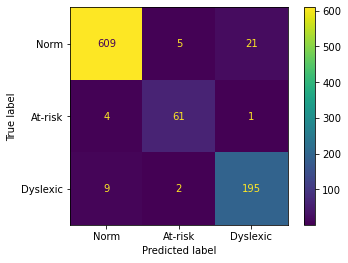

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


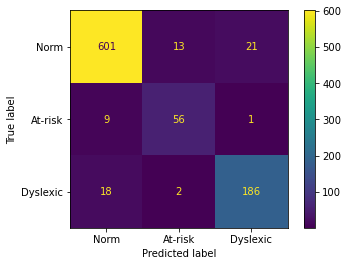

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


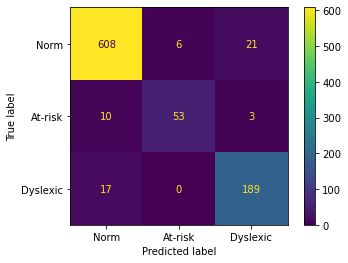

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


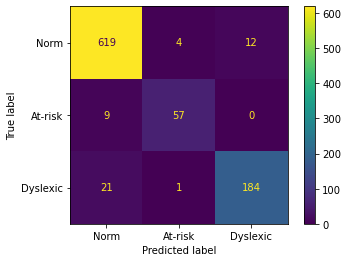

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


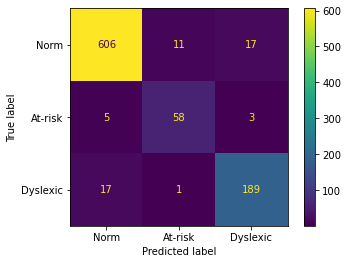

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [28]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [29]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.054 0.075 0.088 0.005 0.941 0.007 0.929 0.013


In [30]:


mdl.fit(x_train, y_train)



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48878D-01    |proj g|=  2.58684D-01

At iterate    1    f=  7.91796D-01    |proj g|=  3.89579D-02

At iterate    2    f=  7.78651D-01    |proj g|=  3.43924D-02

At iterate    3    f=  7.31339D-01    |proj g|=  2.71351D-02

At iterate    4    f=  7.23252D-01    |proj g|=  1.57684D-02

At iterate    5    f=  7.15447D-01    |proj g|=  2.01722D-02

At iterate    6    f=  7.09575D-01    |proj g|=  2.07852D-02

At iterate    7    f=  6.91826D-01    |proj g|=  1.43911D-02

At iterate    8    f=  6.82877D-01    |proj g|=  1.36532D-02

At iterate    9    f=  6.64259D-01    |proj g|=  1.05448D-02

At iterate   10    f=  6.50311D-01    |proj g|=  1.74752D-02

At iterate   11    f=  6.44248D-01    |proj g|=  2.44870D-02

At iterate   12    f=  6.35067D-01    |proj g|=  1.69066D-02

At iterate   13    f=  6.2


At iterate  140    f=  4.08705D-01    |proj g|=  2.21272D-02

At iterate  141    f=  4.07073D-01    |proj g|=  1.18713D-02

At iterate  142    f=  4.05960D-01    |proj g|=  8.40067D-03

At iterate  143    f=  4.04576D-01    |proj g|=  1.16200D-02

At iterate  144    f=  4.03144D-01    |proj g|=  1.07180D-02

At iterate  145    f=  4.01299D-01    |proj g|=  6.21146D-03

At iterate  146    f=  3.99014D-01    |proj g|=  8.12736D-03

At iterate  147    f=  3.97740D-01    |proj g|=  1.03205D-02

At iterate  148    f=  3.96714D-01    |proj g|=  7.72478D-03

At iterate  149    f=  3.95766D-01    |proj g|=  6.44915D-03

At iterate  150    f=  3.94272D-01    |proj g|=  1.09817D-02

At iterate  151    f=  3.92388D-01    |proj g|=  1.20853D-02

At iterate  152    f=  3.91789D-01    |proj g|=  2.12844D-02

At iterate  153    f=  3.90862D-01    |proj g|=  6.48902D-03

At iterate  154    f=  3.90421D-01    |proj g|=  4.51911D-03

At iterate  155    f=  3.89692D-01    |proj g|=  9.62224D-03

At iter


At iterate  299    f=  2.95104D-01    |proj g|=  4.09157D-03

At iterate  300    f=  2.94837D-01    |proj g|=  1.65914D-02

At iterate  301    f=  2.94144D-01    |proj g|=  4.92388D-03

At iterate  302    f=  2.93707D-01    |proj g|=  6.08710D-03

At iterate  303    f=  2.93281D-01    |proj g|=  5.27635D-03

At iterate  304    f=  2.92419D-01    |proj g|=  6.88633D-03

At iterate  305    f=  2.91682D-01    |proj g|=  9.13041D-03

At iterate  306    f=  2.90863D-01    |proj g|=  4.75498D-03

At iterate  307    f=  2.90483D-01    |proj g|=  3.83373D-03

At iterate  308    f=  2.89645D-01    |proj g|=  4.12100D-03

At iterate  309    f=  2.89358D-01    |proj g|=  1.95518D-02

At iterate  310    f=  2.88357D-01    |proj g|=  5.22814D-03

At iterate  311    f=  2.87960D-01    |proj g|=  2.83401D-03

At iterate  312    f=  2.87390D-01    |proj g|=  4.40223D-03

At iterate  313    f=  2.87220D-01    |proj g|=  8.24357D-03

At iterate  314    f=  2.86825D-01    |proj g|=  5.20390D-03

At iter


At iterate  441    f=  2.36639D-01    |proj g|=  2.65160D-03

At iterate  442    f=  2.36251D-01    |proj g|=  3.33941D-03

At iterate  443    f=  2.35819D-01    |proj g|=  5.42573D-03

At iterate  444    f=  2.35344D-01    |proj g|=  2.86252D-03

At iterate  445    f=  2.34888D-01    |proj g|=  3.35839D-03

At iterate  446    f=  2.34451D-01    |proj g|=  6.72025D-03

At iterate  447    f=  2.34352D-01    |proj g|=  7.95180D-03

At iterate  448    f=  2.34068D-01    |proj g|=  2.58764D-03

At iterate  449    f=  2.33979D-01    |proj g|=  2.37017D-03

At iterate  450    f=  2.33805D-01    |proj g|=  4.23149D-03

At iterate  451    f=  2.33507D-01    |proj g|=  5.01155D-03

At iterate  452    f=  2.33119D-01    |proj g|=  8.18617D-03

At iterate  453    f=  2.32640D-01    |proj g|=  3.87542D-03

At iterate  454    f=  2.32368D-01    |proj g|=  1.93843D-03

At iterate  455    f=  2.32129D-01    |proj g|=  2.35263D-03

At iterate  456    f=  2.31994D-01    |proj g|=  4.37803D-03

At iter


At iterate  591    f=  1.97466D-01    |proj g|=  2.09555D-03

At iterate  592    f=  1.97300D-01    |proj g|=  4.44822D-03

At iterate  593    f=  1.97002D-01    |proj g|=  4.04141D-03

At iterate  594    f=  1.96883D-01    |proj g|=  4.60265D-03

At iterate  595    f=  1.96689D-01    |proj g|=  2.63262D-03

At iterate  596    f=  1.96536D-01    |proj g|=  2.64784D-03

At iterate  597    f=  1.96344D-01    |proj g|=  3.42065D-03

At iterate  598    f=  1.96194D-01    |proj g|=  4.31649D-03

At iterate  599    f=  1.96044D-01    |proj g|=  1.80683D-03

At iterate  600    f=  1.95927D-01    |proj g|=  2.08364D-03

At iterate  601    f=  1.95771D-01    |proj g|=  2.30625D-03

At iterate  602    f=  1.95552D-01    |proj g|=  1.14983D-02

At iterate  603    f=  1.95357D-01    |proj g|=  2.43746D-03

At iterate  604    f=  1.95272D-01    |proj g|=  1.93536D-03

At iterate  605    f=  1.95122D-01    |proj g|=  1.73842D-03

At iterate  606    f=  1.94874D-01    |proj g|=  2.65763D-03

At iter


At iterate  745    f=  1.70309D-01    |proj g|=  2.41973D-03

At iterate  746    f=  1.70237D-01    |proj g|=  2.81506D-03

At iterate  747    f=  1.70153D-01    |proj g|=  4.31630D-03

At iterate  748    f=  1.69944D-01    |proj g|=  5.61860D-03

At iterate  749    f=  1.69799D-01    |proj g|=  6.23383D-03

At iterate  750    f=  1.69595D-01    |proj g|=  4.84173D-03

At iterate  751    f=  1.69494D-01    |proj g|=  3.30980D-03

At iterate  752    f=  1.69341D-01    |proj g|=  3.54124D-03

At iterate  753    f=  1.69163D-01    |proj g|=  4.12499D-03

At iterate  754    f=  1.68965D-01    |proj g|=  2.65395D-03

At iterate  755    f=  1.68769D-01    |proj g|=  2.03269D-03

At iterate  756    f=  1.68656D-01    |proj g|=  9.69999D-03

At iterate  757    f=  1.68454D-01    |proj g|=  3.40982D-03

At iterate  758    f=  1.68324D-01    |proj g|=  1.63696D-03

At iterate  759    f=  1.68102D-01    |proj g|=  3.63627D-03

At iterate  760    f=  1.67912D-01    |proj g|=  3.54083D-03

At iter


At iterate  902    f=  1.45878D-01    |proj g|=  1.70792D-03

At iterate  903    f=  1.45798D-01    |proj g|=  1.94804D-03

At iterate  904    f=  1.45529D-01    |proj g|=  3.00601D-03

At iterate  905    f=  1.45401D-01    |proj g|=  5.98723D-03

At iterate  906    f=  1.45225D-01    |proj g|=  2.60729D-03

At iterate  907    f=  1.45166D-01    |proj g|=  2.52493D-03

At iterate  908    f=  1.45082D-01    |proj g|=  2.29914D-03

At iterate  909    f=  1.44971D-01    |proj g|=  1.76853D-03

At iterate  910    f=  1.44748D-01    |proj g|=  3.44295D-03

At iterate  911    f=  1.44625D-01    |proj g|=  8.44478D-03

At iterate  912    f=  1.44465D-01    |proj g|=  2.87034D-03

At iterate  913    f=  1.44387D-01    |proj g|=  3.17224D-03

At iterate  914    f=  1.44327D-01    |proj g|=  2.94785D-03

At iterate  915    f=  1.44263D-01    |proj g|=  2.72705D-03

At iterate  916    f=  1.43984D-01    |proj g|=  2.33808D-03

At iterate  917    f=  1.43800D-01    |proj g|=  3.61069D-03

At iter


At iterate 1061    f=  1.30729D-01    |proj g|=  2.67734D-03

At iterate 1062    f=  1.30668D-01    |proj g|=  2.28719D-03

At iterate 1063    f=  1.30573D-01    |proj g|=  1.35931D-03

At iterate 1064    f=  1.30528D-01    |proj g|=  5.91084D-03

At iterate 1065    f=  1.30450D-01    |proj g|=  3.27530D-03

At iterate 1066    f=  1.30388D-01    |proj g|=  2.63449D-03

At iterate 1067    f=  1.30303D-01    |proj g|=  2.41850D-03

At iterate 1068    f=  1.30177D-01    |proj g|=  2.32897D-03

At iterate 1069    f=  1.30059D-01    |proj g|=  5.90008D-03

At iterate 1070    f=  1.29939D-01    |proj g|=  2.02681D-03

At iterate 1071    f=  1.29856D-01    |proj g|=  1.42159D-03

At iterate 1072    f=  1.29804D-01    |proj g|=  8.08429D-03

At iterate 1073    f=  1.29725D-01    |proj g|=  5.02541D-03

At iterate 1074    f=  1.29623D-01    |proj g|=  2.11415D-03

At iterate 1075    f=  1.29508D-01    |proj g|=  2.09611D-03

At iterate 1076    f=  1.29395D-01    |proj g|=  4.35633D-03

At iter


At iterate 1195    f=  1.21119D-01    |proj g|=  2.36375D-03

At iterate 1196    f=  1.21076D-01    |proj g|=  5.21109D-03

At iterate 1197    f=  1.21011D-01    |proj g|=  1.41061D-03

At iterate 1198    f=  1.20977D-01    |proj g|=  1.14581D-03

At iterate 1199    f=  1.20909D-01    |proj g|=  2.13171D-03

At iterate 1200    f=  1.20894D-01    |proj g|=  7.43178D-03

At iterate 1201    f=  1.20817D-01    |proj g|=  1.51548D-03

At iterate 1202    f=  1.20787D-01    |proj g|=  1.92387D-03

At iterate 1203    f=  1.20745D-01    |proj g|=  1.93566D-03

At iterate 1204    f=  1.20665D-01    |proj g|=  3.00415D-03

At iterate 1205    f=  1.20598D-01    |proj g|=  5.36716D-03

At iterate 1206    f=  1.20490D-01    |proj g|=  2.13630D-03

At iterate 1207    f=  1.20423D-01    |proj g|=  2.43913D-03

At iterate 1208    f=  1.20315D-01    |proj g|=  3.82975D-03

At iterate 1209    f=  1.20179D-01    |proj g|=  3.34493D-03

At iterate 1210    f=  1.20101D-01    |proj g|=  5.64033D-03

At iter


At iterate 1338    f=  1.09935D-01    |proj g|=  6.55898D-03

At iterate 1339    f=  1.09827D-01    |proj g|=  3.80449D-03

At iterate 1340    f=  1.09801D-01    |proj g|=  7.93053D-03

At iterate 1341    f=  1.09740D-01    |proj g|=  4.64536D-03

At iterate 1342    f=  1.09703D-01    |proj g|=  3.43540D-03

At iterate 1343    f=  1.09635D-01    |proj g|=  4.80477D-03

At iterate 1344    f=  1.09540D-01    |proj g|=  4.60385D-03

At iterate 1345    f=  1.09423D-01    |proj g|=  7.75837D-03

At iterate 1346    f=  1.09338D-01    |proj g|=  6.55193D-03

At iterate 1347    f=  1.09274D-01    |proj g|=  3.45486D-03

At iterate 1348    f=  1.09190D-01    |proj g|=  2.88674D-03

At iterate 1349    f=  1.09123D-01    |proj g|=  3.99014D-03

At iterate 1350    f=  1.08958D-01    |proj g|=  5.73283D-03

At iterate 1351    f=  1.08898D-01    |proj g|=  5.26338D-03

At iterate 1352    f=  1.08805D-01    |proj g|=  1.80554D-03

At iterate 1353    f=  1.08728D-01    |proj g|=  6.25373D-03

At iter


At iterate 1487    f=  1.02665D-01    |proj g|=  3.78938D-03

At iterate 1488    f=  1.02612D-01    |proj g|=  3.16628D-03

At iterate 1489    f=  1.02553D-01    |proj g|=  1.97464D-03

At iterate 1490    f=  1.02515D-01    |proj g|=  2.26075D-03

At iterate 1491    f=  1.02491D-01    |proj g|=  4.43373D-03

At iterate 1492    f=  1.02466D-01    |proj g|=  3.22123D-03

At iterate 1493    f=  1.02410D-01    |proj g|=  1.82914D-03

At iterate 1494    f=  1.02364D-01    |proj g|=  1.59847D-03

At iterate 1495    f=  1.02320D-01    |proj g|=  2.95053D-03

At iterate 1496    f=  1.02302D-01    |proj g|=  3.05488D-03

At iterate 1497    f=  1.02281D-01    |proj g|=  2.26497D-03

At iterate 1498    f=  1.02248D-01    |proj g|=  1.42268D-03

At iterate 1499    f=  1.02232D-01    |proj g|=  7.77936D-03

At iterate 1500    f=  1.02205D-01    |proj g|=  4.06318D-03

At iterate 1501    f=  1.02162D-01    |proj g|=  2.68677D-03

At iterate 1502    f=  1.02142D-01    |proj g|=  3.61551D-03

At iter


At iterate 1672    f=  9.78704D-02    |proj g|=  2.32905D-03

At iterate 1673    f=  9.78062D-02    |proj g|=  3.10060D-03

At iterate 1674    f=  9.77925D-02    |proj g|=  5.43611D-03

At iterate 1675    f=  9.77437D-02    |proj g|=  3.08864D-03

At iterate 1676    f=  9.76977D-02    |proj g|=  1.04845D-03

At iterate 1677    f=  9.76588D-02    |proj g|=  1.10645D-03

At iterate 1678    f=  9.76158D-02    |proj g|=  1.43352D-03

At iterate 1679    f=  9.75810D-02    |proj g|=  6.58961D-03

At iterate 1680    f=  9.75074D-02    |proj g|=  4.17453D-03

At iterate 1681    f=  9.74761D-02    |proj g|=  6.27032D-03

At iterate 1682    f=  9.74487D-02    |proj g|=  1.79133D-03

At iterate 1683    f=  9.74307D-02    |proj g|=  1.79675D-03

At iterate 1684    f=  9.74022D-02    |proj g|=  2.80259D-03

At iterate 1685    f=  9.73412D-02    |proj g|=  2.74144D-03

At iterate 1686    f=  9.73142D-02    |proj g|=  3.69346D-03

At iterate 1687    f=  9.72660D-02    |proj g|=  3.09651D-03

At iter


At iterate 1842    f=  9.34905D-02    |proj g|=  1.03031D-03

At iterate 1843    f=  9.34822D-02    |proj g|=  5.81009D-03

At iterate 1844    f=  9.34690D-02    |proj g|=  1.19446D-03

At iterate 1845    f=  9.34567D-02    |proj g|=  2.24766D-03

At iterate 1846    f=  9.34315D-02    |proj g|=  4.75747D-03

At iterate 1847    f=  9.34072D-02    |proj g|=  4.28257D-03

At iterate 1848    f=  9.33651D-02    |proj g|=  6.28195D-03

At iterate 1849    f=  9.33495D-02    |proj g|=  3.56954D-03

At iterate 1850    f=  9.33287D-02    |proj g|=  1.17236D-03

At iterate 1851    f=  9.33169D-02    |proj g|=  1.37188D-03

At iterate 1852    f=  9.33055D-02    |proj g|=  1.65901D-03

At iterate 1853    f=  9.32742D-02    |proj g|=  1.87024D-03

At iterate 1854    f=  9.32587D-02    |proj g|=  4.01982D-03

At iterate 1855    f=  9.32320D-02    |proj g|=  2.75786D-03

At iterate 1856    f=  9.32114D-02    |proj g|=  6.42976D-03

At iterate 1857    f=  9.31952D-02    |proj g|=  1.91871D-03

At iter


At iterate 2015    f=  9.08507D-02    |proj g|=  2.31687D-03

At iterate 2016    f=  9.08338D-02    |proj g|=  7.86379D-04

At iterate 2017    f=  9.08247D-02    |proj g|=  8.26983D-04

At iterate 2018    f=  9.08063D-02    |proj g|=  1.20921D-03

At iterate 2019    f=  9.07633D-02    |proj g|=  2.33442D-03

At iterate 2020    f=  9.07460D-02    |proj g|=  3.00876D-03

At iterate 2021    f=  9.07203D-02    |proj g|=  1.22696D-03

At iterate 2022    f=  9.07020D-02    |proj g|=  2.15618D-03

At iterate 2023    f=  9.06948D-02    |proj g|=  3.06292D-03

At iterate 2024    f=  9.06830D-02    |proj g|=  1.52722D-03

At iterate 2025    f=  9.06638D-02    |proj g|=  8.54665D-04

At iterate 2026    f=  9.06452D-02    |proj g|=  1.23720D-03

At iterate 2027    f=  9.06406D-02    |proj g|=  9.58541D-03

At iterate 2028    f=  9.06145D-02    |proj g|=  2.11067D-03

At iterate 2029    f=  9.06043D-02    |proj g|=  9.16789D-04

At iterate 2030    f=  9.05880D-02    |proj g|=  1.56684D-03

At iter


At iterate 2179    f=  8.74013D-02    |proj g|=  2.12650D-03

At iterate 2180    f=  8.73879D-02    |proj g|=  3.70094D-03

At iterate 2181    f=  8.73690D-02    |proj g|=  2.34771D-03

At iterate 2182    f=  8.73554D-02    |proj g|=  1.70936D-03

At iterate 2183    f=  8.73425D-02    |proj g|=  4.27633D-03

At iterate 2184    f=  8.73282D-02    |proj g|=  2.45691D-03

At iterate 2185    f=  8.73037D-02    |proj g|=  1.83465D-03

At iterate 2186    f=  8.72969D-02    |proj g|=  4.44067D-03

At iterate 2187    f=  8.72857D-02    |proj g|=  3.36823D-03

At iterate 2188    f=  8.72635D-02    |proj g|=  1.15883D-03

At iterate 2189    f=  8.72444D-02    |proj g|=  1.15821D-03

At iterate 2190    f=  8.72161D-02    |proj g|=  2.64328D-03

At iterate 2191    f=  8.71790D-02    |proj g|=  2.03872D-03

At iterate 2192    f=  8.71585D-02    |proj g|=  4.04728D-03

At iterate 2193    f=  8.71382D-02    |proj g|=  1.61402D-03

At iterate 2194    f=  8.71247D-02    |proj g|=  1.26669D-03

At iter


At iterate 2345    f=  8.43621D-02    |proj g|=  6.14766D-03

At iterate 2346    f=  8.43413D-02    |proj g|=  2.09568D-03

At iterate 2347    f=  8.43305D-02    |proj g|=  1.01183D-03

At iterate 2348    f=  8.43185D-02    |proj g|=  1.21059D-03

At iterate 2349    f=  8.43038D-02    |proj g|=  1.53954D-03

At iterate 2350    f=  8.42958D-02    |proj g|=  5.39078D-03

At iterate 2351    f=  8.42746D-02    |proj g|=  2.77117D-03

At iterate 2352    f=  8.42575D-02    |proj g|=  1.07394D-03

At iterate 2353    f=  8.42342D-02    |proj g|=  1.29345D-03

At iterate 2354    f=  8.42222D-02    |proj g|=  1.00662D-02

At iterate 2355    f=  8.41900D-02    |proj g|=  4.37274D-03

At iterate 2356    f=  8.41681D-02    |proj g|=  1.22776D-03

At iterate 2357    f=  8.41536D-02    |proj g|=  1.91179D-03

At iterate 2358    f=  8.41345D-02    |proj g|=  3.17407D-03

At iterate 2359    f=  8.41233D-02    |proj g|=  4.41510D-03

At iterate 2360    f=  8.41094D-02    |proj g|=  1.33287D-03

At iter


At iterate 2479    f=  8.22179D-02    |proj g|=  2.47676D-03

At iterate 2480    f=  8.22027D-02    |proj g|=  1.02616D-02

At iterate 2481    f=  8.21614D-02    |proj g|=  1.69397D-03

At iterate 2482    f=  8.21499D-02    |proj g|=  1.02141D-03

At iterate 2483    f=  8.21403D-02    |proj g|=  2.83359D-03

At iterate 2484    f=  8.21325D-02    |proj g|=  1.07691D-03

At iterate 2485    f=  8.21241D-02    |proj g|=  2.21320D-03

At iterate 2486    f=  8.21044D-02    |proj g|=  3.10632D-03

At iterate 2487    f=  8.20987D-02    |proj g|=  4.31413D-03

At iterate 2488    f=  8.20880D-02    |proj g|=  1.59736D-03

At iterate 2489    f=  8.20814D-02    |proj g|=  8.63617D-04

At iterate 2490    f=  8.20706D-02    |proj g|=  1.97033D-03

At iterate 2491    f=  8.20565D-02    |proj g|=  2.85057D-03

At iterate 2492    f=  8.20362D-02    |proj g|=  2.96913D-03

At iterate 2493    f=  8.20267D-02    |proj g|=  3.14497D-03

At iterate 2494    f=  8.20055D-02    |proj g|=  2.33907D-03

At iter


At iterate 2642    f=  8.05732D-02    |proj g|=  5.34150D-03

At iterate 2643    f=  8.05633D-02    |proj g|=  1.67323D-03

At iterate 2644    f=  8.05566D-02    |proj g|=  7.81010D-04

At iterate 2645    f=  8.05482D-02    |proj g|=  2.29418D-03

At iterate 2646    f=  8.05380D-02    |proj g|=  2.54204D-03

At iterate 2647    f=  8.05342D-02    |proj g|=  4.49027D-03

At iterate 2648    f=  8.05227D-02    |proj g|=  2.32381D-03

At iterate 2649    f=  8.05098D-02    |proj g|=  8.88610D-04

At iterate 2650    f=  8.04900D-02    |proj g|=  7.36310D-04

At iterate 2651    f=  8.04729D-02    |proj g|=  9.45365D-04

At iterate 2652    f=  8.04597D-02    |proj g|=  3.29913D-03

At iterate 2653    f=  8.04530D-02    |proj g|=  7.02553D-03

At iterate 2654    f=  8.04394D-02    |proj g|=  1.07755D-03

At iterate 2655    f=  8.04346D-02    |proj g|=  1.71522D-03

At iterate 2656    f=  8.04261D-02    |proj g|=  2.48194D-03

At iterate 2657    f=  8.04064D-02    |proj g|=  3.26167D-03

At iter


At iterate 2821    f=  7.93081D-02    |proj g|=  1.19193D-03

At iterate 2822    f=  7.92960D-02    |proj g|=  2.39250D-03

At iterate 2823    f=  7.92910D-02    |proj g|=  3.64914D-03

At iterate 2824    f=  7.92835D-02    |proj g|=  2.10809D-03

At iterate 2825    f=  7.92751D-02    |proj g|=  8.02539D-04

At iterate 2826    f=  7.92694D-02    |proj g|=  1.03967D-03

At iterate 2827    f=  7.92586D-02    |proj g|=  1.28053D-03

At iterate 2828    f=  7.92471D-02    |proj g|=  3.66090D-03

At iterate 2829    f=  7.92424D-02    |proj g|=  2.75936D-03

At iterate 2830    f=  7.92376D-02    |proj g|=  1.19921D-03

At iterate 2831    f=  7.92330D-02    |proj g|=  7.06443D-04

At iterate 2832    f=  7.92273D-02    |proj g|=  1.60302D-03

At iterate 2833    f=  7.92171D-02    |proj g|=  2.15444D-03

At iterate 2834    f=  7.92026D-02    |proj g|=  5.67117D-03

At iterate 2835    f=  7.91965D-02    |proj g|=  1.32673D-03

At iterate 2836    f=  7.91913D-02    |proj g|=  9.84696D-04

At iter


At iterate 3003    f=  7.82004D-02    |proj g|=  5.05757D-04

At iterate 3004    f=  7.81904D-02    |proj g|=  1.08476D-03

At iterate 3005    f=  7.81821D-02    |proj g|=  3.41025D-03

At iterate 3006    f=  7.81738D-02    |proj g|=  1.84021D-03

At iterate 3007    f=  7.81699D-02    |proj g|=  5.35749D-04

At iterate 3008    f=  7.81675D-02    |proj g|=  6.69027D-04

At iterate 3009    f=  7.81655D-02    |proj g|=  3.07922D-03

At iterate 3010    f=  7.81612D-02    |proj g|=  1.64902D-03

At iterate 3011    f=  7.81564D-02    |proj g|=  1.36476D-03

At iterate 3012    f=  7.81534D-02    |proj g|=  1.47163D-03

At iterate 3013    f=  7.81507D-02    |proj g|=  2.32045D-03

At iterate 3014    f=  7.81462D-02    |proj g|=  1.36373D-03

At iterate 3015    f=  7.81409D-02    |proj g|=  2.74446D-03

At iterate 3016    f=  7.81344D-02    |proj g|=  2.46388D-03

At iterate 3017    f=  7.81256D-02    |proj g|=  2.74858D-03

At iterate 3018    f=  7.81233D-02    |proj g|=  1.60701D-03

At iter


At iterate 3190    f=  7.69495D-02    |proj g|=  3.44227D-03

At iterate 3191    f=  7.69387D-02    |proj g|=  1.43274D-03

At iterate 3192    f=  7.69318D-02    |proj g|=  8.82537D-04

At iterate 3193    f=  7.69245D-02    |proj g|=  4.77589D-03

At iterate 3194    f=  7.69172D-02    |proj g|=  1.71123D-03

At iterate 3195    f=  7.69125D-02    |proj g|=  1.02087D-03

At iterate 3196    f=  7.69026D-02    |proj g|=  1.15322D-03

At iterate 3197    f=  7.68897D-02    |proj g|=  1.65120D-03

At iterate 3198    f=  7.68660D-02    |proj g|=  1.23800D-03

At iterate 3199    f=  7.68563D-02    |proj g|=  3.78015D-03

At iterate 3200    f=  7.68348D-02    |proj g|=  8.84601D-04

At iterate 3201    f=  7.68228D-02    |proj g|=  1.70125D-03

At iterate 3202    f=  7.68174D-02    |proj g|=  2.77050D-03

At iterate 3203    f=  7.68106D-02    |proj g|=  8.97575D-04

At iterate 3204    f=  7.68055D-02    |proj g|=  8.69329D-04

At iterate 3205    f=  7.67985D-02    |proj g|=  2.63615D-03

At iter


At iterate 3351    f=  7.58288D-02    |proj g|=  8.41358D-04

At iterate 3352    f=  7.58236D-02    |proj g|=  2.06358D-03

At iterate 3353    f=  7.58174D-02    |proj g|=  9.65832D-04

At iterate 3354    f=  7.58105D-02    |proj g|=  2.42806D-03

At iterate 3355    f=  7.58022D-02    |proj g|=  2.00589D-03

At iterate 3356    f=  7.57914D-02    |proj g|=  1.36066D-03

At iterate 3357    f=  7.57853D-02    |proj g|=  1.43288D-03

At iterate 3358    f=  7.57811D-02    |proj g|=  3.56720D-03

At iterate 3359    f=  7.57756D-02    |proj g|=  1.94761D-03

At iterate 3360    f=  7.57697D-02    |proj g|=  1.18777D-03

At iterate 3361    f=  7.57683D-02    |proj g|=  2.00528D-03

At iterate 3362    f=  7.57664D-02    |proj g|=  1.15230D-03

At iterate 3363    f=  7.57624D-02    |proj g|=  1.27379D-03

At iterate 3364    f=  7.57553D-02    |proj g|=  2.71281D-03

At iterate 3365    f=  7.57452D-02    |proj g|=  3.11056D-03

At iterate 3366    f=  7.57324D-02    |proj g|=  5.33552D-03

At iter

At iterate 3485    f=  7.50424D-02    |proj g|=  3.70748D-03

At iterate 3486    f=  7.50341D-02    |proj g|=  2.24694D-03

At iterate 3487    f=  7.50260D-02    |proj g|=  1.15583D-03

At iterate 3488    f=  7.50157D-02    |proj g|=  2.61835D-03

At iterate 3489    f=  7.50126D-02    |proj g|=  3.32522D-03

At iterate 3490    f=  7.50066D-02    |proj g|=  2.30558D-03

At iterate 3491    f=  7.49975D-02    |proj g|=  1.12284D-03

At iterate 3492    f=  7.49843D-02    |proj g|=  9.07160D-04

At iterate 3493    f=  7.49756D-02    |proj g|=  3.82601D-03

At iterate 3494    f=  7.49671D-02    |proj g|=  1.82887D-03

At iterate 3495    f=  7.49619D-02    |proj g|=  8.42802D-04

At iterate 3496    f=  7.49543D-02    |proj g|=  9.40258D-04

At iterate 3497    f=  7.49473D-02    |proj g|=  8.12464D-04

At iterate 3498    f=  7.49423D-02    |proj g|=  4.06802D-03

At iterate 3499    f=  7.49322D-02    |proj g|=  1.50497D-03

At iterate 3500    f=  7.49241D-02    |proj g|=  1.10198D-03

At itera


At iterate 3643    f=  7.41506D-02    |proj g|=  1.92131D-03

At iterate 3644    f=  7.41481D-02    |proj g|=  8.36444D-04

At iterate 3645    f=  7.41458D-02    |proj g|=  5.04724D-04

At iterate 3646    f=  7.41441D-02    |proj g|=  7.25045D-04

At iterate 3647    f=  7.41392D-02    |proj g|=  1.58429D-03

At iterate 3648    f=  7.41360D-02    |proj g|=  3.65890D-03

At iterate 3649    f=  7.41308D-02    |proj g|=  8.59718D-04

At iterate 3650    f=  7.41280D-02    |proj g|=  1.37854D-03

At iterate 3651    f=  7.41228D-02    |proj g|=  1.35653D-03

At iterate 3652    f=  7.41181D-02    |proj g|=  9.75968D-04

At iterate 3653    f=  7.41145D-02    |proj g|=  2.33388D-03

At iterate 3654    f=  7.41107D-02    |proj g|=  3.79063D-03

At iterate 3655    f=  7.41078D-02    |proj g|=  6.19966D-04

At iterate 3656    f=  7.41061D-02    |proj g|=  7.57133D-04

At iterate 3657    f=  7.41034D-02    |proj g|=  1.05574D-03

At iterate 3658    f=  7.40981D-02    |proj g|=  2.10740D-03

At iter


At iterate 3776    f=  7.35729D-02    |proj g|=  9.15146D-04

At iterate 3777    f=  7.35717D-02    |proj g|=  2.19773D-03

At iterate 3778    f=  7.35690D-02    |proj g|=  1.28583D-03

At iterate 3779    f=  7.35673D-02    |proj g|=  7.25178D-04

At iterate 3780    f=  7.35648D-02    |proj g|=  2.37152D-03

At iterate 3781    f=  7.35617D-02    |proj g|=  1.01692D-03

At iterate 3782    f=  7.35586D-02    |proj g|=  1.19546D-03

At iterate 3783    f=  7.35547D-02    |proj g|=  1.05032D-03

At iterate 3784    f=  7.35492D-02    |proj g|=  3.82823D-03

At iterate 3785    f=  7.35438D-02    |proj g|=  1.90313D-03

At iterate 3786    f=  7.35408D-02    |proj g|=  7.88362D-04

At iterate 3787    f=  7.35382D-02    |proj g|=  6.68507D-04

At iterate 3788    f=  7.35362D-02    |proj g|=  5.48330D-04

At iterate 3789    f=  7.35317D-02    |proj g|=  1.56656D-03

At iterate 3790    f=  7.35303D-02    |proj g|=  3.60040D-03

At iterate 3791    f=  7.35270D-02    |proj g|=  5.93860D-04

At iter


At iterate 3944    f=  7.30239D-02    |proj g|=  9.78727D-04

At iterate 3945    f=  7.30231D-02    |proj g|=  2.44198D-03

At iterate 3946    f=  7.30217D-02    |proj g|=  1.70092D-03

At iterate 3947    f=  7.30173D-02    |proj g|=  1.18963D-03

At iterate 3948    f=  7.30134D-02    |proj g|=  1.32849D-03

At iterate 3949    f=  7.30074D-02    |proj g|=  2.18606D-03

At iterate 3950    f=  7.30044D-02    |proj g|=  2.03278D-03

At iterate 3951    f=  7.30013D-02    |proj g|=  9.69276D-04

At iterate 3952    f=  7.29995D-02    |proj g|=  7.55799D-04

At iterate 3953    f=  7.29965D-02    |proj g|=  9.77066D-04

At iterate 3954    f=  7.29910D-02    |proj g|=  1.55643D-03

At iterate 3955    f=  7.29866D-02    |proj g|=  6.45821D-04

At iterate 3956    f=  7.29825D-02    |proj g|=  5.23754D-04

At iterate 3957    f=  7.29815D-02    |proj g|=  3.00598D-03

At iterate 3958    f=  7.29785D-02    |proj g|=  2.10315D-03

At iterate 3959    f=  7.29745D-02    |proj g|=  5.34889D-04

At iter


At iterate 4113    f=  7.24651D-02    |proj g|=  6.25235D-04

At iterate 4114    f=  7.24644D-02    |proj g|=  8.99874D-04

At iterate 4115    f=  7.24624D-02    |proj g|=  8.06057D-04

At iterate 4116    f=  7.24603D-02    |proj g|=  2.41126D-03

At iterate 4117    f=  7.24556D-02    |proj g|=  9.71794D-04

At iterate 4118    f=  7.24528D-02    |proj g|=  2.37826D-03

At iterate 4119    f=  7.24507D-02    |proj g|=  8.19507D-04

At iterate 4120    f=  7.24497D-02    |proj g|=  5.22865D-04

At iterate 4121    f=  7.24468D-02    |proj g|=  5.48316D-04

At iterate 4122    f=  7.24429D-02    |proj g|=  1.22478D-03

At iterate 4123    f=  7.24370D-02    |proj g|=  1.23324D-03

At iterate 4124    f=  7.24340D-02    |proj g|=  3.73929D-03

At iterate 4125    f=  7.24296D-02    |proj g|=  8.83565D-04

At iterate 4126    f=  7.24263D-02    |proj g|=  1.07704D-03

At iterate 4127    f=  7.24228D-02    |proj g|=  1.94326D-03

At iterate 4128    f=  7.24157D-02    |proj g|=  1.56887D-03

At iter


At iterate 4260    f=  7.19553D-02    |proj g|=  6.38798D-04

At iterate 4261    f=  7.19489D-02    |proj g|=  1.78080D-03

At iterate 4262    f=  7.19472D-02    |proj g|=  1.47803D-03

At iterate 4263    f=  7.19449D-02    |proj g|=  6.68560D-04

At iterate 4264    f=  7.19427D-02    |proj g|=  5.53345D-04

At iterate 4265    f=  7.19394D-02    |proj g|=  6.82978D-04

At iterate 4266    f=  7.19358D-02    |proj g|=  1.19862D-03

At iterate 4267    f=  7.19335D-02    |proj g|=  1.45070D-03

At iterate 4268    f=  7.19309D-02    |proj g|=  4.75260D-04

At iterate 4269    f=  7.19284D-02    |proj g|=  1.19492D-03

At iterate 4270    f=  7.19265D-02    |proj g|=  2.58968D-03

At iterate 4271    f=  7.19235D-02    |proj g|=  1.18125D-03

At iterate 4272    f=  7.19187D-02    |proj g|=  7.55354D-04

At iterate 4273    f=  7.19139D-02    |proj g|=  7.00449D-04

At iterate 4274    f=  7.19127D-02    |proj g|=  3.22023D-03

At iterate 4275    f=  7.19097D-02    |proj g|=  1.83725D-03

At iter


At iterate 4397    f=  7.14988D-02    |proj g|=  1.11208D-03

At iterate 4398    f=  7.14969D-02    |proj g|=  1.02596D-03

At iterate 4399    f=  7.14952D-02    |proj g|=  1.42095D-03

At iterate 4400    f=  7.14874D-02    |proj g|=  2.82624D-03

At iterate 4401    f=  7.14824D-02    |proj g|=  1.35412D-03

At iterate 4402    f=  7.14787D-02    |proj g|=  1.59497D-03

At iterate 4403    f=  7.14764D-02    |proj g|=  8.19374D-04

At iterate 4404    f=  7.14742D-02    |proj g|=  1.88545D-03

At iterate 4405    f=  7.14714D-02    |proj g|=  2.20666D-03

At iterate 4406    f=  7.14643D-02    |proj g|=  2.98368D-03

At iterate 4407    f=  7.14618D-02    |proj g|=  3.60617D-03

At iterate 4408    f=  7.14576D-02    |proj g|=  1.16064D-03

At iterate 4409    f=  7.14552D-02    |proj g|=  1.00073D-03

At iterate 4410    f=  7.14531D-02    |proj g|=  1.53942D-03

At iterate 4411    f=  7.14486D-02    |proj g|=  1.85972D-03

At iterate 4412    f=  7.14466D-02    |proj g|=  2.22418D-03

At iter


At iterate 4530    f=  7.10113D-02    |proj g|=  1.15445D-03

At iterate 4531    f=  7.10079D-02    |proj g|=  1.50303D-03

At iterate 4532    f=  7.10020D-02    |proj g|=  1.08186D-03

At iterate 4533    f=  7.09997D-02    |proj g|=  3.15280D-03

At iterate 4534    f=  7.09971D-02    |proj g|=  6.89692D-04

At iterate 4535    f=  7.09957D-02    |proj g|=  1.11839D-03

At iterate 4536    f=  7.09943D-02    |proj g|=  1.65460D-03

At iterate 4537    f=  7.09899D-02    |proj g|=  2.26485D-03

At iterate 4538    f=  7.09842D-02    |proj g|=  3.67477D-03

At iterate 4539    f=  7.09805D-02    |proj g|=  3.76903D-03

At iterate 4540    f=  7.09764D-02    |proj g|=  9.18949D-04

At iterate 4541    f=  7.09747D-02    |proj g|=  9.04012D-04

At iterate 4542    f=  7.09734D-02    |proj g|=  1.32137D-03

At iterate 4543    f=  7.09698D-02    |proj g|=  1.56617D-03

At iterate 4544    f=  7.09651D-02    |proj g|=  1.96855D-03

At iterate 4545    f=  7.09642D-02    |proj g|=  1.29545D-03

At iter


At iterate 4704    f=  7.05901D-02    |proj g|=  1.22684D-03

At iterate 4705    f=  7.05889D-02    |proj g|=  2.96711D-03

At iterate 4706    f=  7.05870D-02    |proj g|=  7.17522D-04

At iterate 4707    f=  7.05861D-02    |proj g|=  5.13637D-04

At iterate 4708    f=  7.05852D-02    |proj g|=  9.03873D-04

At iterate 4709    f=  7.05831D-02    |proj g|=  1.06701D-03

At iterate 4710    f=  7.05789D-02    |proj g|=  1.28711D-03

At iterate 4711    f=  7.05779D-02    |proj g|=  2.63641D-03

At iterate 4712    f=  7.05746D-02    |proj g|=  9.95943D-04

At iterate 4713    f=  7.05722D-02    |proj g|=  5.76097D-04

At iterate 4714    f=  7.05695D-02    |proj g|=  7.99477D-04

At iterate 4715    f=  7.05649D-02    |proj g|=  1.51723D-03

At iterate 4716    f=  7.05614D-02    |proj g|=  3.66058D-03

At iterate 4717    f=  7.05577D-02    |proj g|=  1.71130D-03

At iterate 4718    f=  7.05548D-02    |proj g|=  8.30078D-04

At iterate 4719    f=  7.05533D-02    |proj g|=  8.60280D-04

At iter


At iterate 4843    f=  7.01990D-02    |proj g|=  2.97285D-03

At iterate 4844    f=  7.01905D-02    |proj g|=  7.46362D-04

At iterate 4845    f=  7.01875D-02    |proj g|=  1.00046D-03

At iterate 4846    f=  7.01839D-02    |proj g|=  2.73064D-03

At iterate 4847    f=  7.01806D-02    |proj g|=  1.25855D-03

At iterate 4848    f=  7.01776D-02    |proj g|=  1.54591D-03

At iterate 4849    f=  7.01750D-02    |proj g|=  1.35257D-03

At iterate 4850    f=  7.01738D-02    |proj g|=  2.17455D-03

At iterate 4851    f=  7.01720D-02    |proj g|=  7.10752D-04

At iterate 4852    f=  7.01707D-02    |proj g|=  1.29155D-03

At iterate 4853    f=  7.01686D-02    |proj g|=  1.53806D-03

At iterate 4854    f=  7.01657D-02    |proj g|=  1.28850D-03

At iterate 4855    f=  7.01604D-02    |proj g|=  1.16962D-03

At iterate 4856    f=  7.01562D-02    |proj g|=  1.57819D-03

At iterate 4857    f=  7.01539D-02    |proj g|=  2.55721D-03

At iterate 4858    f=  7.01509D-02    |proj g|=  1.37020D-03

At iter


At iterate 4977    f=  6.98466D-02    |proj g|=  6.15622D-04

At iterate 4978    f=  6.98450D-02    |proj g|=  7.95453D-04

At iterate 4979    f=  6.98426D-02    |proj g|=  1.45083D-03

At iterate 4980    f=  6.98414D-02    |proj g|=  2.20756D-03

At iterate 4981    f=  6.98393D-02    |proj g|=  7.20922D-04

At iterate 4982    f=  6.98377D-02    |proj g|=  5.89008D-04

At iterate 4983    f=  6.98356D-02    |proj g|=  1.15757D-03

At iterate 4984    f=  6.98323D-02    |proj g|=  1.41786D-03

At iterate 4985    f=  6.98279D-02    |proj g|=  1.49996D-03

At iterate 4986    f=  6.98272D-02    |proj g|=  9.66704D-04

At iterate 4987    f=  6.98251D-02    |proj g|=  5.39721D-04

At iterate 4988    f=  6.98229D-02    |proj g|=  5.58686D-04

At iterate 4989    f=  6.98195D-02    |proj g|=  1.73873D-03

At iterate 4990    f=  6.98160D-02    |proj g|=  2.66364D-03

At iterate 4991    f=  6.98135D-02    |proj g|=  2.27239D-03

At iterate 4992    f=  6.98117D-02    |proj g|=  9.20043D-04

At iter


At iterate 5133    f=  6.95880D-02    |proj g|=  1.07455D-03

At iterate 5134    f=  6.95872D-02    |proj g|=  9.80461D-04

At iterate 5135    f=  6.95859D-02    |proj g|=  3.53292D-04

At iterate 5136    f=  6.95850D-02    |proj g|=  4.64378D-04

At iterate 5137    f=  6.95837D-02    |proj g|=  1.38214D-03

At iterate 5138    f=  6.95821D-02    |proj g|=  3.97728D-04

At iterate 5139    f=  6.95808D-02    |proj g|=  1.30081D-03

At iterate 5140    f=  6.95804D-02    |proj g|=  1.37131D-03

At iterate 5141    f=  6.95799D-02    |proj g|=  9.18672D-04

At iterate 5142    f=  6.95787D-02    |proj g|=  4.11793D-04

At iterate 5143    f=  6.95768D-02    |proj g|=  6.13602D-04

At iterate 5144    f=  6.95748D-02    |proj g|=  8.78498D-04

At iterate 5145    f=  6.95716D-02    |proj g|=  1.32465D-03

At iterate 5146    f=  6.95707D-02    |proj g|=  1.10490D-03

At iterate 5147    f=  6.95696D-02    |proj g|=  5.67682D-04

At iterate 5148    f=  6.95686D-02    |proj g|=  5.21171D-04

At iter


At iterate 5289    f=  6.93316D-02    |proj g|=  1.15375D-03

At iterate 5290    f=  6.93295D-02    |proj g|=  7.04144D-04

At iterate 5291    f=  6.93270D-02    |proj g|=  1.61361D-03

At iterate 5292    f=  6.93250D-02    |proj g|=  1.00062D-03

At iterate 5293    f=  6.93242D-02    |proj g|=  1.21035D-03

At iterate 5294    f=  6.93235D-02    |proj g|=  4.77901D-04

At iterate 5295    f=  6.93229D-02    |proj g|=  5.61602D-04

At iterate 5296    f=  6.93200D-02    |proj g|=  7.66322D-04

At iterate 5297    f=  6.93162D-02    |proj g|=  9.06333D-04

At iterate 5298    f=  6.93130D-02    |proj g|=  3.06016D-03

At iterate 5299    f=  6.93113D-02    |proj g|=  1.92312D-03

At iterate 5300    f=  6.93095D-02    |proj g|=  1.17791D-03

At iterate 5301    f=  6.93064D-02    |proj g|=  5.74692D-04

At iterate 5302    f=  6.93032D-02    |proj g|=  6.26051D-04

At iterate 5303    f=  6.93006D-02    |proj g|=  2.51568D-03

At iterate 5304    f=  6.92974D-02    |proj g|=  1.17359D-03

At iter


At iterate 5432    f=  6.90482D-02    |proj g|=  3.46118D-03

At iterate 5433    f=  6.90467D-02    |proj g|=  9.23867D-04

At iterate 5434    f=  6.90461D-02    |proj g|=  6.37606D-04

At iterate 5435    f=  6.90453D-02    |proj g|=  1.28235D-03

At iterate 5436    f=  6.90440D-02    |proj g|=  1.75922D-03

At iterate 5437    f=  6.90412D-02    |proj g|=  2.05601D-03

At iterate 5438    f=  6.90404D-02    |proj g|=  1.81911D-03

At iterate 5439    f=  6.90383D-02    |proj g|=  7.87392D-04

At iterate 5440    f=  6.90368D-02    |proj g|=  5.90964D-04

At iterate 5441    f=  6.90346D-02    |proj g|=  2.27539D-03

At iterate 5442    f=  6.90324D-02    |proj g|=  1.21494D-03

At iterate 5443    f=  6.90298D-02    |proj g|=  1.03793D-03

At iterate 5444    f=  6.90275D-02    |proj g|=  1.26965D-03

At iterate 5445    f=  6.90260D-02    |proj g|=  3.26035D-03

At iterate 5446    f=  6.90240D-02    |proj g|=  1.33887D-03

At iterate 5447    f=  6.90230D-02    |proj g|=  9.87802D-04

At iter


At iterate 5593    f=  6.87320D-02    |proj g|=  1.49559D-03

At iterate 5594    f=  6.87260D-02    |proj g|=  2.47613D-03

At iterate 5595    f=  6.87231D-02    |proj g|=  5.40262D-03

At iterate 5596    f=  6.87166D-02    |proj g|=  1.00710D-03

At iterate 5597    f=  6.87141D-02    |proj g|=  8.02005D-04

At iterate 5598    f=  6.87116D-02    |proj g|=  3.54139D-03

At iterate 5599    f=  6.87078D-02    |proj g|=  2.00666D-03

At iterate 5600    f=  6.87032D-02    |proj g|=  1.04441D-03

At iterate 5601    f=  6.87009D-02    |proj g|=  1.91872D-03

At iterate 5602    f=  6.86992D-02    |proj g|=  1.86859D-03

At iterate 5603    f=  6.86980D-02    |proj g|=  1.45551D-03

At iterate 5604    f=  6.86940D-02    |proj g|=  7.67669D-04

At iterate 5605    f=  6.86896D-02    |proj g|=  1.16744D-03

At iterate 5606    f=  6.86839D-02    |proj g|=  1.23844D-03

At iterate 5607    f=  6.86809D-02    |proj g|=  3.60285D-03

At iterate 5608    f=  6.86732D-02    |proj g|=  1.89372D-03

At iter


At iterate 5762    f=  6.81513D-02    |proj g|=  1.06602D-03

At iterate 5763    f=  6.81490D-02    |proj g|=  9.89467D-04

At iterate 5764    f=  6.81457D-02    |proj g|=  6.45777D-03

At iterate 5765    f=  6.81418D-02    |proj g|=  1.42409D-03

At iterate 5766    f=  6.81400D-02    |proj g|=  1.31885D-03

At iterate 5767    f=  6.81367D-02    |proj g|=  2.18192D-03

At iterate 5768    f=  6.81309D-02    |proj g|=  3.57158D-03

At iterate 5769    f=  6.81234D-02    |proj g|=  2.96365D-03

At iterate 5770    f=  6.81190D-02    |proj g|=  4.84374D-03

At iterate 5771    f=  6.81103D-02    |proj g|=  1.78620D-03

At iterate 5772    f=  6.81058D-02    |proj g|=  2.61290D-03

At iterate 5773    f=  6.81017D-02    |proj g|=  3.81401D-03

At iterate 5774    f=  6.80956D-02    |proj g|=  4.19322D-03

At iterate 5775    f=  6.80858D-02    |proj g|=  2.14056D-03

At iterate 5776    f=  6.80805D-02    |proj g|=  1.89001D-03

At iterate 5777    f=  6.80769D-02    |proj g|=  1.39495D-03

At iter


At iterate 5901    f=  6.75994D-02    |proj g|=  1.63626D-03

At iterate 5902    f=  6.75960D-02    |proj g|=  1.07472D-03

At iterate 5903    f=  6.75919D-02    |proj g|=  4.93694D-03

At iterate 5904    f=  6.75872D-02    |proj g|=  2.12572D-03

At iterate 5905    f=  6.75835D-02    |proj g|=  1.07054D-03

At iterate 5906    f=  6.75823D-02    |proj g|=  1.01138D-03

At iterate 5907    f=  6.75802D-02    |proj g|=  4.63986D-03

At iterate 5908    f=  6.75763D-02    |proj g|=  2.05082D-03

At iterate 5909    f=  6.75735D-02    |proj g|=  7.98625D-04

At iterate 5910    f=  6.75714D-02    |proj g|=  1.42681D-03

At iterate 5911    f=  6.75686D-02    |proj g|=  1.34073D-03

At iterate 5912    f=  6.75668D-02    |proj g|=  2.24042D-03

At iterate 5913    f=  6.75636D-02    |proj g|=  9.00208D-04

At iterate 5914    f=  6.75611D-02    |proj g|=  9.55407D-04

At iterate 5915    f=  6.75566D-02    |proj g|=  1.83244D-03

At iterate 5916    f=  6.75503D-02    |proj g|=  4.23650D-03

At iter


At iterate 6050    f=  6.71866D-02    |proj g|=  6.97426D-04

At iterate 6051    f=  6.71863D-02    |proj g|=  7.36661D-04

At iterate 6052    f=  6.71856D-02    |proj g|=  1.64166D-03

At iterate 6053    f=  6.71840D-02    |proj g|=  2.77951D-03

At iterate 6054    f=  6.71809D-02    |proj g|=  3.51980D-03

At iterate 6055    f=  6.71767D-02    |proj g|=  3.49342D-03

At iterate 6056    f=  6.71741D-02    |proj g|=  3.20596D-03

At iterate 6057    f=  6.71713D-02    |proj g|=  8.12407D-04

At iterate 6058    f=  6.71702D-02    |proj g|=  1.00496D-03

At iterate 6059    f=  6.71694D-02    |proj g|=  1.58698D-03

At iterate 6060    f=  6.71670D-02    |proj g|=  3.13886D-03

At iterate 6061    f=  6.71642D-02    |proj g|=  8.75949D-04

At iterate 6062    f=  6.71620D-02    |proj g|=  2.37230D-03

At iterate 6063    f=  6.71597D-02    |proj g|=  9.40822D-04

At iterate 6064    f=  6.71581D-02    |proj g|=  1.35218D-03

At iterate 6065    f=  6.71566D-02    |proj g|=  1.39386D-03

At iter


At iterate 6188    f=  6.68775D-02    |proj g|=  6.96681D-04

At iterate 6189    f=  6.68753D-02    |proj g|=  1.42041D-03

At iterate 6190    f=  6.68722D-02    |proj g|=  2.07045D-03

At iterate 6191    f=  6.68680D-02    |proj g|=  1.75025D-03

At iterate 6192    f=  6.68660D-02    |proj g|=  1.82459D-03

At iterate 6193    f=  6.68643D-02    |proj g|=  7.33870D-04

At iterate 6194    f=  6.68634D-02    |proj g|=  1.09738D-03

At iterate 6195    f=  6.68624D-02    |proj g|=  1.58163D-03

At iterate 6196    f=  6.68596D-02    |proj g|=  1.88032D-03

At iterate 6197    f=  6.68560D-02    |proj g|=  2.00796D-03

At iterate 6198    f=  6.68541D-02    |proj g|=  4.59504D-03

At iterate 6199    f=  6.68519D-02    |proj g|=  7.62080D-04

At iterate 6200    f=  6.68513D-02    |proj g|=  8.79293D-04

At iterate 6201    f=  6.68507D-02    |proj g|=  1.44122D-03

At iterate 6202    f=  6.68491D-02    |proj g|=  1.86692D-03

At iterate 6203    f=  6.68464D-02    |proj g|=  1.72409D-03

At iter


At iterate 6342    f=  6.64380D-02    |proj g|=  8.27994D-04

At iterate 6343    f=  6.64339D-02    |proj g|=  8.06181D-04

At iterate 6344    f=  6.64333D-02    |proj g|=  5.93850D-03

At iterate 6345    f=  6.64294D-02    |proj g|=  7.65312D-04

At iterate 6346    f=  6.64282D-02    |proj g|=  7.11564D-04

At iterate 6347    f=  6.64278D-02    |proj g|=  4.71835D-03

At iterate 6348    f=  6.64244D-02    |proj g|=  1.01979D-03

At iterate 6349    f=  6.64229D-02    |proj g|=  5.35936D-04

At iterate 6350    f=  6.64201D-02    |proj g|=  1.96277D-03

At iterate 6351    f=  6.64173D-02    |proj g|=  2.18874D-03

At iterate 6352    f=  6.64158D-02    |proj g|=  3.61209D-03

At iterate 6353    f=  6.64120D-02    |proj g|=  1.82660D-03

At iterate 6354    f=  6.64085D-02    |proj g|=  2.11179D-03

At iterate 6355    f=  6.64057D-02    |proj g|=  2.08486D-03

At iterate 6356    f=  6.64021D-02    |proj g|=  1.53377D-03

At iterate 6357    f=  6.63993D-02    |proj g|=  2.52024D-03

At iter


At iterate 6485    f=  6.60948D-02    |proj g|=  2.59789D-03

At iterate 6486    f=  6.60914D-02    |proj g|=  2.41522D-03

At iterate 6487    f=  6.60888D-02    |proj g|=  9.72545D-04

At iterate 6488    f=  6.60869D-02    |proj g|=  9.60248D-04

At iterate 6489    f=  6.60846D-02    |proj g|=  8.66399D-04

At iterate 6490    f=  6.60802D-02    |proj g|=  8.13105D-04

At iterate 6491    f=  6.60795D-02    |proj g|=  2.87075D-03

At iterate 6492    f=  6.60769D-02    |proj g|=  2.05122D-03

At iterate 6493    f=  6.60741D-02    |proj g|=  8.81933D-04

At iterate 6494    f=  6.60706D-02    |proj g|=  7.03189D-04

At iterate 6495    f=  6.60679D-02    |proj g|=  8.62350D-04

At iterate 6496    f=  6.60637D-02    |proj g|=  9.23526D-04

At iterate 6497    f=  6.60623D-02    |proj g|=  2.77178D-03

At iterate 6498    f=  6.60604D-02    |proj g|=  9.96869D-04

At iterate 6499    f=  6.60596D-02    |proj g|=  9.87668D-04

At iterate 6500    f=  6.60542D-02    |proj g|=  1.04380D-03

At iter


At iterate 6628    f=  6.57941D-02    |proj g|=  6.00335D-04

At iterate 6629    f=  6.57920D-02    |proj g|=  8.27639D-04

At iterate 6630    f=  6.57913D-02    |proj g|=  2.24493D-03

At iterate 6631    f=  6.57901D-02    |proj g|=  1.52540D-03

At iterate 6632    f=  6.57884D-02    |proj g|=  6.16454D-04

At iterate 6633    f=  6.57880D-02    |proj g|=  5.87923D-03

At iterate 6634    f=  6.57854D-02    |proj g|=  8.69184D-04

At iterate 6635    f=  6.57847D-02    |proj g|=  6.76909D-04

At iterate 6636    f=  6.57837D-02    |proj g|=  8.81854D-04

At iterate 6637    f=  6.57820D-02    |proj g|=  1.15459D-03

At iterate 6638    f=  6.57784D-02    |proj g|=  1.77339D-03

At iterate 6639    f=  6.57766D-02    |proj g|=  9.84272D-04

At iterate 6640    f=  6.57734D-02    |proj g|=  8.03059D-04

At iterate 6641    f=  6.57674D-02    |proj g|=  2.47476D-03

At iterate 6642    f=  6.57654D-02    |proj g|=  1.60081D-03

At iterate 6643    f=  6.57635D-02    |proj g|=  1.24098D-03

At iter


At iterate 6812    f=  6.54199D-02    |proj g|=  1.85200D-03

At iterate 6813    f=  6.54175D-02    |proj g|=  1.25818D-03

At iterate 6814    f=  6.54143D-02    |proj g|=  6.55221D-04

At iterate 6815    f=  6.54118D-02    |proj g|=  1.27920D-03

At iterate 6816    f=  6.54109D-02    |proj g|=  1.82262D-03

At iterate 6817    f=  6.54095D-02    |proj g|=  1.12479D-03

At iterate 6818    f=  6.54078D-02    |proj g|=  6.08440D-04

At iterate 6819    f=  6.54069D-02    |proj g|=  1.95240D-03

At iterate 6820    f=  6.54057D-02    |proj g|=  1.81629D-03

At iterate 6821    f=  6.54052D-02    |proj g|=  1.13547D-03

At iterate 6822    f=  6.54042D-02    |proj g|=  3.07345D-04

At iterate 6823    f=  6.54033D-02    |proj g|=  7.42861D-04

At iterate 6824    f=  6.54019D-02    |proj g|=  1.00638D-03

At iterate 6825    f=  6.53993D-02    |proj g|=  1.28650D-03

At iterate 6826    f=  6.53959D-02    |proj g|=  2.72466D-03

At iterate 6827    f=  6.53947D-02    |proj g|=  3.92480D-03

At iter


At iterate 6977    f=  6.51295D-02    |proj g|=  1.54125D-03

At iterate 6978    f=  6.51282D-02    |proj g|=  2.27060D-03

At iterate 6979    f=  6.51267D-02    |proj g|=  1.04462D-03

At iterate 6980    f=  6.51250D-02    |proj g|=  1.13270D-03

At iterate 6981    f=  6.51232D-02    |proj g|=  1.86743D-03

At iterate 6982    f=  6.51211D-02    |proj g|=  2.08120D-03

At iterate 6983    f=  6.51193D-02    |proj g|=  1.73009D-03

At iterate 6984    f=  6.51168D-02    |proj g|=  7.49648D-04

At iterate 6985    f=  6.51156D-02    |proj g|=  5.19179D-04

At iterate 6986    f=  6.51122D-02    |proj g|=  1.49638D-03

At iterate 6987    f=  6.51086D-02    |proj g|=  1.14399D-03

At iterate 6988    f=  6.51081D-02    |proj g|=  4.36936D-03

At iterate 6989    f=  6.51043D-02    |proj g|=  8.63157D-04

At iterate 6990    f=  6.51034D-02    |proj g|=  1.00947D-03

At iterate 6991    f=  6.51023D-02    |proj g|=  1.27943D-03

At iterate 6992    f=  6.51007D-02    |proj g|=  3.10031D-03

At iter


At iterate 7118    f=  6.48267D-02    |proj g|=  1.44175D-03

At iterate 7119    f=  6.48262D-02    |proj g|=  1.47291D-03

At iterate 7120    f=  6.48234D-02    |proj g|=  9.39837D-04

At iterate 7121    f=  6.48214D-02    |proj g|=  2.05554D-03

At iterate 7122    f=  6.48188D-02    |proj g|=  9.62988D-04

At iterate 7123    f=  6.48153D-02    |proj g|=  7.97154D-04

At iterate 7124    f=  6.48115D-02    |proj g|=  1.17089D-03

At iterate 7125    f=  6.48063D-02    |proj g|=  2.69922D-03

At iterate 7126    f=  6.48039D-02    |proj g|=  2.49817D-03

At iterate 7127    f=  6.48017D-02    |proj g|=  8.09770D-04

At iterate 7128    f=  6.48002D-02    |proj g|=  6.33259D-04

At iterate 7129    f=  6.47968D-02    |proj g|=  9.68070D-04

At iterate 7130    f=  6.47921D-02    |proj g|=  1.01305D-03

At iterate 7131    f=  6.47917D-02    |proj g|=  2.67261D-03

At iterate 7132    f=  6.47887D-02    |proj g|=  1.18404D-03

At iterate 7133    f=  6.47866D-02    |proj g|=  1.06731D-03

At iter


At iterate 7263    f=  6.44936D-02    |proj g|=  1.02096D-03

At iterate 7264    f=  6.44899D-02    |proj g|=  1.27730D-03

At iterate 7265    f=  6.44874D-02    |proj g|=  6.54050D-04

At iterate 7266    f=  6.44869D-02    |proj g|=  2.23221D-03

At iterate 7267    f=  6.44861D-02    |proj g|=  1.35862D-03

At iterate 7268    f=  6.44847D-02    |proj g|=  5.78846D-04

At iterate 7269    f=  6.44827D-02    |proj g|=  1.16422D-03

At iterate 7270    f=  6.44802D-02    |proj g|=  1.54385D-03

At iterate 7271    f=  6.44770D-02    |proj g|=  2.33042D-03

At iterate 7272    f=  6.44758D-02    |proj g|=  1.85570D-03

At iterate 7273    f=  6.44741D-02    |proj g|=  6.23724D-04

At iterate 7274    f=  6.44725D-02    |proj g|=  6.33907D-04

At iterate 7275    f=  6.44694D-02    |proj g|=  1.46673D-03

At iterate 7276    f=  6.44665D-02    |proj g|=  2.25432D-03

At iterate 7277    f=  6.44631D-02    |proj g|=  1.98196D-03

At iterate 7278    f=  6.44616D-02    |proj g|=  4.84038D-03

At iter


At iterate 7411    f=  6.41764D-02    |proj g|=  7.77744D-04

At iterate 7412    f=  6.41752D-02    |proj g|=  6.28065D-03

At iterate 7413    f=  6.41714D-02    |proj g|=  2.12889D-03

At iterate 7414    f=  6.41697D-02    |proj g|=  1.17336D-03

At iterate 7415    f=  6.41677D-02    |proj g|=  1.48226D-03

At iterate 7416    f=  6.41646D-02    |proj g|=  1.49698D-03

At iterate 7417    f=  6.41580D-02    |proj g|=  2.84875D-03

At iterate 7418    f=  6.41557D-02    |proj g|=  2.36364D-03

At iterate 7419    f=  6.41536D-02    |proj g|=  1.00509D-03

At iterate 7420    f=  6.41517D-02    |proj g|=  1.06354D-03

At iterate 7421    f=  6.41500D-02    |proj g|=  4.34768D-03

At iterate 7422    f=  6.41468D-02    |proj g|=  3.25018D-03

At iterate 7423    f=  6.41418D-02    |proj g|=  9.74742D-04

At iterate 7424    f=  6.41387D-02    |proj g|=  8.18470D-04

At iterate 7425    f=  6.41373D-02    |proj g|=  4.56582D-03

At iterate 7426    f=  6.41340D-02    |proj g|=  3.53292D-03

At iter


At iterate 7584    f=  6.37324D-02    |proj g|=  8.39182D-04

At iterate 7585    f=  6.37304D-02    |proj g|=  8.37602D-04

At iterate 7586    f=  6.37245D-02    |proj g|=  1.59999D-03

At iterate 7587    f=  6.37229D-02    |proj g|=  2.07278D-03

At iterate 7588    f=  6.37213D-02    |proj g|=  7.35317D-04

At iterate 7589    f=  6.37197D-02    |proj g|=  6.24094D-04

At iterate 7590    f=  6.37175D-02    |proj g|=  1.32191D-03

At iterate 7591    f=  6.37127D-02    |proj g|=  1.78831D-03

At iterate 7592    f=  6.37068D-02    |proj g|=  4.00595D-03

At iterate 7593    f=  6.37042D-02    |proj g|=  4.48235D-03

At iterate 7594    f=  6.37004D-02    |proj g|=  6.09349D-04

At iterate 7595    f=  6.36993D-02    |proj g|=  1.46997D-03

At iterate 7596    f=  6.36974D-02    |proj g|=  1.07465D-03

At iterate 7597    f=  6.36948D-02    |proj g|=  4.32380D-03

At iterate 7598    f=  6.36917D-02    |proj g|=  1.72191D-03

At iterate 7599    f=  6.36897D-02    |proj g|=  7.99570D-04

At iter


At iterate 7728    f=  6.33978D-02    |proj g|=  7.17225D-04

At iterate 7729    f=  6.33964D-02    |proj g|=  5.14767D-03

At iterate 7730    f=  6.33930D-02    |proj g|=  1.22901D-03

At iterate 7731    f=  6.33917D-02    |proj g|=  7.29107D-04

At iterate 7732    f=  6.33902D-02    |proj g|=  9.52417D-04

At iterate 7733    f=  6.33875D-02    |proj g|=  9.50748D-04

At iterate 7734    f=  6.33859D-02    |proj g|=  3.83698D-03

At iterate 7735    f=  6.33826D-02    |proj g|=  1.21395D-03

At iterate 7736    f=  6.33814D-02    |proj g|=  1.02923D-03

At iterate 7737    f=  6.33780D-02    |proj g|=  2.30628D-03

At iterate 7738    f=  6.33756D-02    |proj g|=  9.57716D-04

At iterate 7739    f=  6.33725D-02    |proj g|=  8.78796D-04

At iterate 7740    f=  6.33669D-02    |proj g|=  1.51401D-03

At iterate 7741    f=  6.33655D-02    |proj g|=  2.24314D-03

At iterate 7742    f=  6.33632D-02    |proj g|=  1.52217D-03

At iterate 7743    f=  6.33597D-02    |proj g|=  6.50593D-04

At iter

At iterate 7896    f=  6.30005D-02    |proj g|=  6.42903D-04

At iterate 7897    f=  6.29991D-02    |proj g|=  1.86544D-03

At iterate 7898    f=  6.29966D-02    |proj g|=  1.65022D-03

At iterate 7899    f=  6.29955D-02    |proj g|=  6.34835D-03

At iterate 7900    f=  6.29922D-02    |proj g|=  2.65572D-03

At iterate 7901    f=  6.29899D-02    |proj g|=  1.44963D-03

At iterate 7902    f=  6.29867D-02    |proj g|=  2.21009D-03

At iterate 7903    f=  6.29837D-02    |proj g|=  2.20419D-03

At iterate 7904    f=  6.29799D-02    |proj g|=  1.32370D-03

At iterate 7905    f=  6.29790D-02    |proj g|=  2.72890D-03

At iterate 7906    f=  6.29768D-02    |proj g|=  2.75663D-03

At iterate 7907    f=  6.29733D-02    |proj g|=  2.49028D-03

At iterate 7908    f=  6.29708D-02    |proj g|=  9.41047D-04

At iterate 7909    f=  6.29689D-02    |proj g|=  9.19413D-04

At iterate 7910    f=  6.29669D-02    |proj g|=  1.64162D-03

At iterate 7911    f=  6.29640D-02    |proj g|=  2.35729D-03

At itera


At iterate 8036    f=  6.25886D-02    |proj g|=  8.11264D-04

At iterate 8037    f=  6.25865D-02    |proj g|=  3.39770D-03

At iterate 8038    f=  6.25852D-02    |proj g|=  3.40609D-03

At iterate 8039    f=  6.25843D-02    |proj g|=  1.10091D-03

At iterate 8040    f=  6.25834D-02    |proj g|=  7.35939D-04

At iterate 8041    f=  6.25817D-02    |proj g|=  2.53813D-03

At iterate 8042    f=  6.25793D-02    |proj g|=  3.51831D-03

At iterate 8043    f=  6.25757D-02    |proj g|=  3.34716D-03

At iterate 8044    f=  6.25747D-02    |proj g|=  2.22415D-03

At iterate 8045    f=  6.25704D-02    |proj g|=  1.74220D-03

At iterate 8046    f=  6.25683D-02    |proj g|=  2.23740D-03

At iterate 8047    f=  6.25652D-02    |proj g|=  8.92750D-04

At iterate 8048    f=  6.25624D-02    |proj g|=  1.25263D-03

At iterate 8049    f=  6.25574D-02    |proj g|=  4.59971D-03

At iterate 8050    f=  6.25526D-02    |proj g|=  1.64011D-03

At iterate 8051    f=  6.25487D-02    |proj g|=  1.06891D-03

At iter


At iterate 8223    f=  6.20319D-02    |proj g|=  1.92615D-03

At iterate 8224    f=  6.20301D-02    |proj g|=  3.48081D-03

At iterate 8225    f=  6.20277D-02    |proj g|=  1.91904D-03

At iterate 8226    f=  6.20246D-02    |proj g|=  1.00740D-03

At iterate 8227    f=  6.20201D-02    |proj g|=  1.82963D-03

At iterate 8228    f=  6.20144D-02    |proj g|=  2.97025D-03

At iterate 8229    f=  6.20127D-02    |proj g|=  2.91132D-03

At iterate 8230    f=  6.20099D-02    |proj g|=  1.28192D-03

At iterate 8231    f=  6.20078D-02    |proj g|=  1.00357D-03

At iterate 8232    f=  6.20031D-02    |proj g|=  1.26669D-03

At iterate 8233    f=  6.19969D-02    |proj g|=  1.84046D-03

At iterate 8234    f=  6.19874D-02    |proj g|=  1.60622D-03

At iterate 8235    f=  6.19861D-02    |proj g|=  4.15201D-03

At iterate 8236    f=  6.19824D-02    |proj g|=  2.00331D-03

At iterate 8237    f=  6.19795D-02    |proj g|=  1.10988D-03

At iterate 8238    f=  6.19771D-02    |proj g|=  1.37989D-03

At iter


At iterate 8402    f=  6.14720D-02    |proj g|=  1.82630D-03

At iterate 8403    f=  6.14701D-02    |proj g|=  2.94959D-03

At iterate 8404    f=  6.14676D-02    |proj g|=  1.57852D-03

At iterate 8405    f=  6.14634D-02    |proj g|=  8.91829D-04

At iterate 8406    f=  6.14610D-02    |proj g|=  1.15770D-03

At iterate 8407    f=  6.14601D-02    |proj g|=  3.03154D-03

At iterate 8408    f=  6.14579D-02    |proj g|=  1.38023D-03

At iterate 8409    f=  6.14560D-02    |proj g|=  6.99822D-04

At iterate 8410    f=  6.14539D-02    |proj g|=  1.46802D-03

At iterate 8411    f=  6.14535D-02    |proj g|=  2.09479D-03

At iterate 8412    f=  6.14522D-02    |proj g|=  9.30837D-04

At iterate 8413    f=  6.14511D-02    |proj g|=  6.12097D-04

At iterate 8414    f=  6.14493D-02    |proj g|=  1.46348D-03

At iterate 8415    f=  6.14472D-02    |proj g|=  1.81397D-03

At iterate 8416    f=  6.14461D-02    |proj g|=  3.22068D-03

At iterate 8417    f=  6.14445D-02    |proj g|=  1.49665D-03

At iter


At iterate 8547    f=  6.12536D-02    |proj g|=  1.27974D-03

At iterate 8548    f=  6.12524D-02    |proj g|=  1.05570D-03

At iterate 8549    f=  6.12511D-02    |proj g|=  3.83697D-03

At iterate 8550    f=  6.12496D-02    |proj g|=  1.79330D-03

At iterate 8551    f=  6.12481D-02    |proj g|=  1.23118D-03

At iterate 8552    f=  6.12476D-02    |proj g|=  1.10309D-03

At iterate 8553    f=  6.12461D-02    |proj g|=  3.39133D-03

At iterate 8554    f=  6.12446D-02    |proj g|=  1.84729D-03

At iterate 8555    f=  6.12438D-02    |proj g|=  8.12645D-04

At iterate 8556    f=  6.12428D-02    |proj g|=  6.81794D-04

At iterate 8557    f=  6.12419D-02    |proj g|=  9.82543D-04

At iterate 8558    f=  6.12403D-02    |proj g|=  7.30656D-04

At iterate 8559    f=  6.12395D-02    |proj g|=  1.82121D-03

At iterate 8560    f=  6.12381D-02    |proj g|=  1.04473D-03

At iterate 8561    f=  6.12362D-02    |proj g|=  1.27703D-03

At iterate 8562    f=  6.12354D-02    |proj g|=  2.66823D-03

At iter


At iterate 8715    f=  6.09252D-02    |proj g|=  2.40796D-03

At iterate 8716    f=  6.09219D-02    |proj g|=  2.14928D-03

At iterate 8717    f=  6.09208D-02    |proj g|=  4.00579D-03

At iterate 8718    f=  6.09194D-02    |proj g|=  1.50591D-03

At iterate 8719    f=  6.09181D-02    |proj g|=  1.84528D-03

At iterate 8720    f=  6.09163D-02    |proj g|=  1.96262D-03

At iterate 8721    f=  6.09138D-02    |proj g|=  2.51146D-03

At iterate 8722    f=  6.09099D-02    |proj g|=  2.59048D-03

At iterate 8723    f=  6.09077D-02    |proj g|=  2.33490D-03

At iterate 8724    f=  6.09054D-02    |proj g|=  1.22952D-03

At iterate 8725    f=  6.09036D-02    |proj g|=  1.90780D-03

At iterate 8726    f=  6.09012D-02    |proj g|=  2.90844D-03

At iterate 8727    f=  6.08974D-02    |proj g|=  1.19829D-03

At iterate 8728    f=  6.08950D-02    |proj g|=  7.28804D-03

At iterate 8729    f=  6.08916D-02    |proj g|=  1.60059D-03

At iterate 8730    f=  6.08894D-02    |proj g|=  2.92847D-03

At iter

At iterate 8888    f=  6.06209D-02    |proj g|=  2.15494D-03

At iterate 8889    f=  6.06198D-02    |proj g|=  3.50986D-03

At iterate 8890    f=  6.06181D-02    |proj g|=  1.02596D-03

At iterate 8891    f=  6.06175D-02    |proj g|=  8.52258D-04

At iterate 8892    f=  6.06169D-02    |proj g|=  9.62148D-04

At iterate 8893    f=  6.06161D-02    |proj g|=  1.55050D-03

At iterate 8894    f=  6.06146D-02    |proj g|=  2.00629D-03

At iterate 8895    f=  6.06139D-02    |proj g|=  1.53224D-03

At iterate 8896    f=  6.06123D-02    |proj g|=  9.29626D-04

At iterate 8897    f=  6.06108D-02    |proj g|=  7.77368D-04

At iterate 8898    f=  6.06091D-02    |proj g|=  5.09280D-04

At iterate 8899    f=  6.06083D-02    |proj g|=  3.40397D-03

At iterate 8900    f=  6.06072D-02    |proj g|=  6.57287D-04

At iterate 8901    f=  6.06066D-02    |proj g|=  6.68835D-04

At iterate 8902    f=  6.06059D-02    |proj g|=  7.67662D-04

At iterate 8903    f=  6.06043D-02    |proj g|=  1.10742D-03

At itera


At iterate 9028    f=  6.04556D-02    |proj g|=  6.23041D-04

At iterate 9029    f=  6.04539D-02    |proj g|=  8.51060D-04

At iterate 9030    f=  6.04521D-02    |proj g|=  1.28037D-03

At iterate 9031    f=  6.04512D-02    |proj g|=  2.23580D-03

At iterate 9032    f=  6.04503D-02    |proj g|=  6.76647D-04

At iterate 9033    f=  6.04499D-02    |proj g|=  7.28513D-04

At iterate 9034    f=  6.04483D-02    |proj g|=  1.30734D-03

At iterate 9035    f=  6.04465D-02    |proj g|=  6.89979D-04

At iterate 9036    f=  6.04449D-02    |proj g|=  1.86358D-03

At iterate 9037    f=  6.04446D-02    |proj g|=  4.69390D-03

At iterate 9038    f=  6.04430D-02    |proj g|=  1.02106D-03

At iterate 9039    f=  6.04427D-02    |proj g|=  4.20739D-04

At iterate 9040    f=  6.04422D-02    |proj g|=  6.79668D-04

At iterate 9041    f=  6.04412D-02    |proj g|=  8.52703D-04

At iterate 9042    f=  6.04394D-02    |proj g|=  1.38140D-03

At iterate 9043    f=  6.04389D-02    |proj g|=  1.81887D-03

At iter


At iterate 9175    f=  6.02574D-02    |proj g|=  6.95880D-04

At iterate 9176    f=  6.02561D-02    |proj g|=  1.08988D-03

At iterate 9177    f=  6.02540D-02    |proj g|=  1.81760D-03

At iterate 9178    f=  6.02494D-02    |proj g|=  3.12159D-03

At iterate 9179    f=  6.02465D-02    |proj g|=  3.73398D-03

At iterate 9180    f=  6.02429D-02    |proj g|=  1.43005D-03

At iterate 9181    f=  6.02405D-02    |proj g|=  1.21120D-03

At iterate 9182    f=  6.02389D-02    |proj g|=  3.95724D-03

At iterate 9183    f=  6.02365D-02    |proj g|=  3.32505D-03

At iterate 9184    f=  6.02309D-02    |proj g|=  1.50277D-03

At iterate 9185    f=  6.02290D-02    |proj g|=  3.89906D-03

At iterate 9186    f=  6.02271D-02    |proj g|=  1.55302D-03

At iterate 9187    f=  6.02263D-02    |proj g|=  1.56184D-03

At iterate 9188    f=  6.02241D-02    |proj g|=  8.80256D-04

At iterate 9189    f=  6.02211D-02    |proj g|=  1.44683D-03

At iterate 9190    f=  6.02192D-02    |proj g|=  3.85524D-03

At iter


At iterate 9334    f=  5.99351D-02    |proj g|=  5.09174D-03

At iterate 9335    f=  5.99342D-02    |proj g|=  2.36653D-03

At iterate 9336    f=  5.99330D-02    |proj g|=  6.75578D-04

At iterate 9337    f=  5.99314D-02    |proj g|=  2.63264D-03

At iterate 9338    f=  5.99300D-02    |proj g|=  2.69981D-03

At iterate 9339    f=  5.99280D-02    |proj g|=  4.68699D-03

At iterate 9340    f=  5.99275D-02    |proj g|=  5.46403D-03

At iterate 9341    f=  5.99254D-02    |proj g|=  2.39723D-03

At iterate 9342    f=  5.99248D-02    |proj g|=  7.62212D-04

At iterate 9343    f=  5.99245D-02    |proj g|=  4.89968D-04

At iterate 9344    f=  5.99234D-02    |proj g|=  8.13537D-04

At iterate 9345    f=  5.99225D-02    |proj g|=  9.52525D-04

At iterate 9346    f=  5.99211D-02    |proj g|=  2.46419D-03

At iterate 9347    f=  5.99197D-02    |proj g|=  1.81055D-03

At iterate 9348    f=  5.99187D-02    |proj g|=  1.96617D-03

At iterate 9349    f=  5.99179D-02    |proj g|=  1.05098D-03

At iter


At iterate 9502    f=  5.96354D-02    |proj g|=  1.10801D-03

At iterate 9503    f=  5.96340D-02    |proj g|=  1.30899D-03

At iterate 9504    f=  5.96303D-02    |proj g|=  2.55019D-03

At iterate 9505    f=  5.96279D-02    |proj g|=  5.62924D-03

At iterate 9506    f=  5.96232D-02    |proj g|=  1.97788D-03

At iterate 9507    f=  5.96210D-02    |proj g|=  7.85218D-04

At iterate 9508    f=  5.96197D-02    |proj g|=  8.99728D-04

At iterate 9509    f=  5.96191D-02    |proj g|=  2.58959D-03

At iterate 9510    f=  5.96175D-02    |proj g|=  1.73633D-03

At iterate 9511    f=  5.96146D-02    |proj g|=  7.59773D-04

At iterate 9512    f=  5.96117D-02    |proj g|=  1.94094D-03

At iterate 9513    f=  5.96104D-02    |proj g|=  2.65502D-03

At iterate 9514    f=  5.96093D-02    |proj g|=  1.96628D-03

At iterate 9515    f=  5.96061D-02    |proj g|=  7.67066D-04

At iterate 9516    f=  5.96032D-02    |proj g|=  1.16906D-03

At iterate 9517    f=  5.95984D-02    |proj g|=  1.70605D-03

At iter


At iterate 9657    f=  5.92292D-02    |proj g|=  2.16479D-03

At iterate 9658    f=  5.92281D-02    |proj g|=  6.66520D-04

At iterate 9659    f=  5.92271D-02    |proj g|=  1.11523D-03

At iterate 9660    f=  5.92258D-02    |proj g|=  1.34848D-03

At iterate 9661    f=  5.92222D-02    |proj g|=  1.87212D-03

At iterate 9662    f=  5.92183D-02    |proj g|=  1.99491D-03

At iterate 9663    f=  5.92176D-02    |proj g|=  4.00452D-03

At iterate 9664    f=  5.92158D-02    |proj g|=  3.59694D-03

At iterate 9665    f=  5.92140D-02    |proj g|=  1.18608D-03

At iterate 9666    f=  5.92132D-02    |proj g|=  8.11411D-04

At iterate 9667    f=  5.92117D-02    |proj g|=  8.77216D-04

At iterate 9668    f=  5.92096D-02    |proj g|=  1.02351D-03

At iterate 9669    f=  5.92081D-02    |proj g|=  3.71550D-03

At iterate 9670    f=  5.92050D-02    |proj g|=  2.19140D-03

At iterate 9671    f=  5.92024D-02    |proj g|=  1.18009D-03

At iterate 9672    f=  5.91995D-02    |proj g|=  1.41847D-03

At iter


At iterate 9798    f=  5.89155D-02    |proj g|=  2.24653D-03

At iterate 9799    f=  5.89119D-02    |proj g|=  3.09048D-03

At iterate 9800    f=  5.89071D-02    |proj g|=  2.90653D-03

At iterate 9801    f=  5.89053D-02    |proj g|=  3.97156D-03

At iterate 9802    f=  5.89000D-02    |proj g|=  1.50171D-03

At iterate 9803    f=  5.88973D-02    |proj g|=  6.88221D-04

At iterate 9804    f=  5.88950D-02    |proj g|=  1.66505D-03

At iterate 9805    f=  5.88935D-02    |proj g|=  2.18286D-03

At iterate 9806    f=  5.88919D-02    |proj g|=  1.77249D-03

At iterate 9807    f=  5.88910D-02    |proj g|=  5.90556D-04

At iterate 9808    f=  5.88903D-02    |proj g|=  1.43806D-03

At iterate 9809    f=  5.88895D-02    |proj g|=  1.14616D-03

At iterate 9810    f=  5.88874D-02    |proj g|=  1.15684D-03

At iterate 9811    f=  5.88830D-02    |proj g|=  1.33164D-03

At iterate 9812    f=  5.88791D-02    |proj g|=  1.44380D-03

At iterate 9813    f=  5.88766D-02    |proj g|=  2.37728D-03

At iter


At iterate 9953    f=  5.85823D-02    |proj g|=  9.14248D-04

At iterate 9954    f=  5.85788D-02    |proj g|=  1.96388D-03

At iterate 9955    f=  5.85769D-02    |proj g|=  2.79589D-03

At iterate 9956    f=  5.85750D-02    |proj g|=  6.73628D-04

At iterate 9957    f=  5.85741D-02    |proj g|=  9.26109D-04

At iterate 9958    f=  5.85723D-02    |proj g|=  1.42665D-03

At iterate 9959    f=  5.85718D-02    |proj g|=  8.02231D-03

At iterate 9960    f=  5.85685D-02    |proj g|=  8.45065D-04

At iterate 9961    f=  5.85677D-02    |proj g|=  8.62520D-04

At iterate 9962    f=  5.85665D-02    |proj g|=  1.26997D-03

At iterate 9963    f=  5.85652D-02    |proj g|=  2.31925D-03

At iterate 9964    f=  5.85632D-02    |proj g|=  1.37194D-03

At iterate 9965    f=  5.85613D-02    |proj g|=  7.18041D-04

At iterate 9966    f=  5.85597D-02    |proj g|=  8.24663D-04

At iterate 9967    f=  5.85579D-02    |proj g|=  2.35057D-03

At iterate 9968    f=  5.85554D-02    |proj g|=  1.80386D-03

At iter


At iterate10122    f=  5.82517D-02    |proj g|=  8.12618D-04

At iterate10123    f=  5.82503D-02    |proj g|=  6.77278D-04

At iterate10124    f=  5.82470D-02    |proj g|=  1.45873D-03

At iterate10125    f=  5.82444D-02    |proj g|=  1.79621D-03

At iterate10126    f=  5.82435D-02    |proj g|=  2.21310D-03

At iterate10127    f=  5.82419D-02    |proj g|=  8.12831D-04

At iterate10128    f=  5.82405D-02    |proj g|=  6.88773D-04

At iterate10129    f=  5.82369D-02    |proj g|=  1.22533D-03

At iterate10130    f=  5.82360D-02    |proj g|=  6.77258D-03

At iterate10131    f=  5.82323D-02    |proj g|=  2.46929D-03

At iterate10132    f=  5.82307D-02    |proj g|=  7.41541D-04

At iterate10133    f=  5.82294D-02    |proj g|=  1.25825D-03

At iterate10134    f=  5.82276D-02    |proj g|=  1.72153D-03

At iterate10135    f=  5.82239D-02    |proj g|=  2.00717D-03

At iterate10136    f=  5.82219D-02    |proj g|=  2.62412D-03

At iterate10137    f=  5.82197D-02    |proj g|=  1.20141D-03

At iter


At iterate10257    f=  5.79260D-02    |proj g|=  2.60866D-03

At iterate10258    f=  5.79235D-02    |proj g|=  3.34190D-03

At iterate10259    f=  5.79212D-02    |proj g|=  1.35765D-03

At iterate10260    f=  5.79191D-02    |proj g|=  1.42352D-03

At iterate10261    f=  5.79159D-02    |proj g|=  1.82213D-03

At iterate10262    f=  5.79139D-02    |proj g|=  1.16081D-03

At iterate10263    f=  5.79135D-02    |proj g|=  4.71376D-03

At iterate10264    f=  5.79120D-02    |proj g|=  1.30132D-03

At iterate10265    f=  5.79113D-02    |proj g|=  1.07726D-03

At iterate10266    f=  5.79099D-02    |proj g|=  2.53696D-03

At iterate10267    f=  5.79079D-02    |proj g|=  2.70785D-03

At iterate10268    f=  5.79033D-02    |proj g|=  3.33566D-03

At iterate10269    f=  5.79019D-02    |proj g|=  5.07557D-03

At iterate10270    f=  5.78995D-02    |proj g|=  1.50924D-03

At iterate10271    f=  5.78983D-02    |proj g|=  1.32891D-03

At iterate10272    f=  5.78974D-02    |proj g|=  2.35181D-03

At iter


At iterate10409    f=  5.76650D-02    |proj g|=  1.82893D-03

At iterate10410    f=  5.76632D-02    |proj g|=  5.88294D-03

At iterate10411    f=  5.76603D-02    |proj g|=  1.10739D-03

At iterate10412    f=  5.76591D-02    |proj g|=  1.48490D-03

At iterate10413    f=  5.76577D-02    |proj g|=  1.63930D-03

At iterate10414    f=  5.76550D-02    |proj g|=  9.40234D-04

At iterate10415    f=  5.76546D-02    |proj g|=  5.22655D-03

At iterate10416    f=  5.76528D-02    |proj g|=  1.49638D-03

At iterate10417    f=  5.76524D-02    |proj g|=  7.40497D-04

At iterate10418    f=  5.76520D-02    |proj g|=  3.76908D-04

At iterate10419    f=  5.76511D-02    |proj g|=  7.10945D-04

At iterate10420    f=  5.76496D-02    |proj g|=  1.09559D-03

At iterate10421    f=  5.76472D-02    |proj g|=  1.18282D-03

At iterate10422    f=  5.76468D-02    |proj g|=  3.06677D-03

At iterate10423    f=  5.76446D-02    |proj g|=  1.56400D-03

At iterate10424    f=  5.76432D-02    |proj g|=  4.36530D-04

At iter


At iterate10550    f=  5.73839D-02    |proj g|=  1.22760D-03

At iterate10551    f=  5.73819D-02    |proj g|=  3.55151D-03

At iterate10552    f=  5.73804D-02    |proj g|=  5.99699D-03

At iterate10553    f=  5.73768D-02    |proj g|=  1.95795D-03

At iterate10554    f=  5.73753D-02    |proj g|=  1.20502D-03

At iterate10555    f=  5.73738D-02    |proj g|=  9.34035D-04

At iterate10556    f=  5.73709D-02    |proj g|=  1.05127D-03

At iterate10557    f=  5.73690D-02    |proj g|=  5.84849D-03

At iterate10558    f=  5.73648D-02    |proj g|=  3.16204D-03

At iterate10559    f=  5.73618D-02    |proj g|=  1.18543D-03

At iterate10560    f=  5.73582D-02    |proj g|=  1.28658D-03

At iterate10561    f=  5.73560D-02    |proj g|=  1.81260D-03

At iterate10562    f=  5.73515D-02    |proj g|=  3.28071D-03

At iterate10563    f=  5.73505D-02    |proj g|=  6.14511D-03

At iterate10564    f=  5.73462D-02    |proj g|=  1.50662D-03

At iterate10565    f=  5.73449D-02    |proj g|=  1.33913D-03

At iter


At iterate10703    f=  5.70850D-02    |proj g|=  9.63876D-04

At iterate10704    f=  5.70835D-02    |proj g|=  3.99810D-03

At iterate10705    f=  5.70792D-02    |proj g|=  1.94454D-03

At iterate10706    f=  5.70768D-02    |proj g|=  7.39851D-04

At iterate10707    f=  5.70743D-02    |proj g|=  7.12656D-04

At iterate10708    f=  5.70722D-02    |proj g|=  1.96486D-03

At iterate10709    f=  5.70709D-02    |proj g|=  3.96234D-03

At iterate10710    f=  5.70690D-02    |proj g|=  2.13316D-03

At iterate10711    f=  5.70678D-02    |proj g|=  2.12511D-03

At iterate10712    f=  5.70658D-02    |proj g|=  3.00049D-03

At iterate10713    f=  5.70647D-02    |proj g|=  4.73735D-03

At iterate10714    f=  5.70620D-02    |proj g|=  9.03123D-04

At iterate10715    f=  5.70613D-02    |proj g|=  7.01656D-04

At iterate10716    f=  5.70603D-02    |proj g|=  9.08211D-04

At iterate10717    f=  5.70585D-02    |proj g|=  9.20823D-04

At iterate10718    f=  5.70582D-02    |proj g|=  5.04094D-03

At iter


At iterate10840    f=  5.69147D-02    |proj g|=  1.52422D-03

At iterate10841    f=  5.69144D-02    |proj g|=  5.29742D-04

At iterate10842    f=  5.69140D-02    |proj g|=  6.16993D-04

At iterate10843    f=  5.69134D-02    |proj g|=  7.16305D-04

At iterate10844    f=  5.69117D-02    |proj g|=  1.35146D-03

At iterate10845    f=  5.69112D-02    |proj g|=  9.71149D-04

At iterate10846    f=  5.69097D-02    |proj g|=  7.89952D-04

At iterate10847    f=  5.69080D-02    |proj g|=  7.10814D-04

At iterate10848    f=  5.69062D-02    |proj g|=  2.46987D-03

At iterate10849    f=  5.69037D-02    |proj g|=  1.01101D-03

At iterate10850    f=  5.69009D-02    |proj g|=  1.23291D-03

At iterate10851    f=  5.68993D-02    |proj g|=  3.07635D-03

At iterate10852    f=  5.68975D-02    |proj g|=  1.85591D-03

At iterate10853    f=  5.68962D-02    |proj g|=  8.65404D-04

At iterate10854    f=  5.68947D-02    |proj g|=  9.11523D-04

At iterate10855    f=  5.68929D-02    |proj g|=  1.22911D-03

At iter


At iterate10987    f=  5.67313D-02    |proj g|=  2.99984D-03

At iterate10988    f=  5.67298D-02    |proj g|=  1.62674D-03

At iterate10989    f=  5.67286D-02    |proj g|=  8.69730D-04

At iterate10990    f=  5.67272D-02    |proj g|=  1.12514D-03

At iterate10991    f=  5.67259D-02    |proj g|=  1.23806D-03

At iterate10992    f=  5.67240D-02    |proj g|=  2.69588D-03

At iterate10993    f=  5.67227D-02    |proj g|=  1.91330D-03

At iterate10994    f=  5.67218D-02    |proj g|=  1.09287D-03

At iterate10995    f=  5.67214D-02    |proj g|=  4.69437D-04

At iterate10996    f=  5.67209D-02    |proj g|=  5.07836D-04

At iterate10997    f=  5.67201D-02    |proj g|=  9.20413D-04

At iterate10998    f=  5.67194D-02    |proj g|=  8.11670D-04

At iterate10999    f=  5.67191D-02    |proj g|=  2.12854D-03

At iterate11000    f=  5.67184D-02    |proj g|=  1.35915D-03

At iterate11001    f=  5.67177D-02    |proj g|=  6.13960D-04

At iterate11002    f=  5.67168D-02    |proj g|=  5.66316D-04

At iter


At iterate11126    f=  5.66277D-02    |proj g|=  7.07568D-04

At iterate11127    f=  5.66276D-02    |proj g|=  2.08258D-03

At iterate11128    f=  5.66268D-02    |proj g|=  1.03687D-03

At iterate11129    f=  5.66262D-02    |proj g|=  4.29782D-04

At iterate11130    f=  5.66255D-02    |proj g|=  5.85557D-04

At iterate11131    f=  5.66250D-02    |proj g|=  6.52738D-04

At iterate11132    f=  5.66240D-02    |proj g|=  1.20847D-03

At iterate11133    f=  5.66230D-02    |proj g|=  9.15590D-04

At iterate11134    f=  5.66227D-02    |proj g|=  2.22942D-03

At iterate11135    f=  5.66220D-02    |proj g|=  9.27939D-04

At iterate11136    f=  5.66216D-02    |proj g|=  3.80516D-04

At iterate11137    f=  5.66212D-02    |proj g|=  4.54773D-04

At iterate11138    f=  5.66203D-02    |proj g|=  5.65950D-04

At iterate11139    f=  5.66202D-02    |proj g|=  1.93876D-03

At iterate11140    f=  5.66194D-02    |proj g|=  1.34180D-03

At iterate11141    f=  5.66187D-02    |proj g|=  5.07201D-04

At iter


At iterate11287    f=  5.65449D-02    |proj g|=  1.37102D-03

At iterate11288    f=  5.65444D-02    |proj g|=  8.08123D-04

At iterate11289    f=  5.65439D-02    |proj g|=  5.46688D-04

At iterate11290    f=  5.65434D-02    |proj g|=  5.54441D-04

At iterate11291    f=  5.65426D-02    |proj g|=  8.55742D-04

At iterate11292    f=  5.65425D-02    |proj g|=  1.48131D-03

At iterate11293    f=  5.65420D-02    |proj g|=  6.37418D-04

At iterate11294    f=  5.65416D-02    |proj g|=  4.37812D-04

At iterate11295    f=  5.65410D-02    |proj g|=  6.13579D-04

At iterate11296    f=  5.65403D-02    |proj g|=  8.28949D-04

At iterate11297    f=  5.65391D-02    |proj g|=  9.10942D-04

At iterate11298    f=  5.65386D-02    |proj g|=  1.24915D-03

At iterate11299    f=  5.65377D-02    |proj g|=  1.03504D-03

At iterate11300    f=  5.65372D-02    |proj g|=  5.06014D-04

At iterate11301    f=  5.65369D-02    |proj g|=  5.19105D-04

At iterate11302    f=  5.65363D-02    |proj g|=  4.07436D-04

At iter


At iterate11438    f=  5.64213D-02    |proj g|=  1.93986D-03

At iterate11439    f=  5.64200D-02    |proj g|=  1.48560D-03

At iterate11440    f=  5.64190D-02    |proj g|=  1.10552D-03

At iterate11441    f=  5.64170D-02    |proj g|=  5.09687D-04

At iterate11442    f=  5.64167D-02    |proj g|=  1.52049D-03

At iterate11443    f=  5.64161D-02    |proj g|=  8.72354D-04

At iterate11444    f=  5.64155D-02    |proj g|=  4.08328D-04

At iterate11445    f=  5.64147D-02    |proj g|=  5.68146D-04

At iterate11446    f=  5.64138D-02    |proj g|=  2.12228D-03

At iterate11447    f=  5.64126D-02    |proj g|=  1.06599D-03

At iterate11448    f=  5.64114D-02    |proj g|=  7.16383D-04

At iterate11449    f=  5.64091D-02    |proj g|=  8.87834D-04

At iterate11450    f=  5.64072D-02    |proj g|=  9.06444D-04

At iterate11451    f=  5.64065D-02    |proj g|=  3.61494D-03

At iterate11452    f=  5.64050D-02    |proj g|=  5.53081D-04

At iterate11453    f=  5.64046D-02    |proj g|=  5.03041D-04

At iter


At iterate11586    f=  5.62454D-02    |proj g|=  6.41170D-04

At iterate11587    f=  5.62447D-02    |proj g|=  5.57765D-04

At iterate11588    f=  5.62437D-02    |proj g|=  6.32978D-04

At iterate11589    f=  5.62413D-02    |proj g|=  2.59608D-03

At iterate11590    f=  5.62401D-02    |proj g|=  1.51732D-03

At iterate11591    f=  5.62387D-02    |proj g|=  7.76342D-04

At iterate11592    f=  5.62375D-02    |proj g|=  1.02707D-03

At iterate11593    f=  5.62352D-02    |proj g|=  1.69238D-03

At iterate11594    f=  5.62321D-02    |proj g|=  1.62475D-03

At iterate11595    f=  5.62311D-02    |proj g|=  3.33055D-03

At iterate11596    f=  5.62301D-02    |proj g|=  8.00179D-04

At iterate11597    f=  5.62296D-02    |proj g|=  1.00473D-03

At iterate11598    f=  5.62289D-02    |proj g|=  1.50233D-03

At iterate11599    f=  5.62267D-02    |proj g|=  2.40099D-03

At iterate11600    f=  5.62251D-02    |proj g|=  2.67238D-03

At iterate11601    f=  5.62227D-02    |proj g|=  2.58341D-03

At iter


At iterate11732    f=  5.59560D-02    |proj g|=  5.10536D-03

At iterate11733    f=  5.59537D-02    |proj g|=  3.93905D-03

At iterate11734    f=  5.59519D-02    |proj g|=  1.08405D-03

At iterate11735    f=  5.59512D-02    |proj g|=  1.24238D-03

At iterate11736    f=  5.59499D-02    |proj g|=  1.56020D-03

At iterate11737    f=  5.59469D-02    |proj g|=  2.02801D-03

At iterate11738    f=  5.59453D-02    |proj g|=  2.94509D-03

At iterate11739    f=  5.59433D-02    |proj g|=  2.10059D-03

At iterate11740    f=  5.59415D-02    |proj g|=  1.37650D-03

At iterate11741    f=  5.59399D-02    |proj g|=  1.69778D-03

At iterate11742    f=  5.59363D-02    |proj g|=  1.77179D-03

At iterate11743    f=  5.59323D-02    |proj g|=  5.23201D-03

At iterate11744    f=  5.59300D-02    |proj g|=  3.13192D-03

At iterate11745    f=  5.59277D-02    |proj g|=  2.52424D-03

At iterate11746    f=  5.59246D-02    |proj g|=  1.03941D-03

At iterate11747    f=  5.59229D-02    |proj g|=  1.21048D-03

At iter


At iterate11903    f=  5.56900D-02    |proj g|=  7.83484D-04

At iterate11904    f=  5.56893D-02    |proj g|=  2.90330D-03

At iterate11905    f=  5.56883D-02    |proj g|=  1.47799D-03

At iterate11906    f=  5.56875D-02    |proj g|=  4.52704D-04

At iterate11907    f=  5.56866D-02    |proj g|=  8.60899D-04

At iterate11908    f=  5.56853D-02    |proj g|=  1.39409D-03

At iterate11909    f=  5.56836D-02    |proj g|=  8.60731D-04

At iterate11910    f=  5.56829D-02    |proj g|=  2.14008D-03

At iterate11911    f=  5.56820D-02    |proj g|=  1.59708D-03

At iterate11912    f=  5.56814D-02    |proj g|=  1.03662D-03

At iterate11913    f=  5.56809D-02    |proj g|=  8.78894D-04

At iterate11914    f=  5.56800D-02    |proj g|=  2.29514D-03

At iterate11915    f=  5.56792D-02    |proj g|=  1.36695D-03

At iterate11916    f=  5.56785D-02    |proj g|=  1.16131D-03

At iterate11917    f=  5.56780D-02    |proj g|=  7.88377D-04

At iterate11918    f=  5.56774D-02    |proj g|=  6.78407D-04

At iter


At iterate12068    f=  5.55261D-02    |proj g|=  2.12457D-03

At iterate12069    f=  5.55258D-02    |proj g|=  1.48522D-03

At iterate12070    f=  5.55246D-02    |proj g|=  8.23183D-04

At iterate12071    f=  5.55232D-02    |proj g|=  1.34562D-03

At iterate12072    f=  5.55220D-02    |proj g|=  6.10408D-04

At iterate12073    f=  5.55211D-02    |proj g|=  5.99903D-04

At iterate12074    f=  5.55196D-02    |proj g|=  1.38986D-03

At iterate12075    f=  5.55192D-02    |proj g|=  2.38616D-03

At iterate12076    f=  5.55183D-02    |proj g|=  6.86747D-04

At iterate12077    f=  5.55180D-02    |proj g|=  4.09029D-04

At iterate12078    f=  5.55176D-02    |proj g|=  6.54710D-04

At iterate12079    f=  5.55168D-02    |proj g|=  8.90981D-04

At iterate12080    f=  5.55165D-02    |proj g|=  3.42278D-03

At iterate12081    f=  5.55156D-02    |proj g|=  2.13363D-03

At iterate12082    f=  5.55147D-02    |proj g|=  6.68586D-04

At iterate12083    f=  5.55138D-02    |proj g|=  7.22997D-04

At iter


At iterate12245    f=  5.54053D-02    |proj g|=  6.40734D-04

At iterate12246    f=  5.54049D-02    |proj g|=  7.49911D-04

At iterate12247    f=  5.54047D-02    |proj g|=  1.41457D-03

At iterate12248    f=  5.54042D-02    |proj g|=  6.46376D-04

At iterate12249    f=  5.54038D-02    |proj g|=  7.44243D-04

At iterate12250    f=  5.54035D-02    |proj g|=  6.99033D-04

At iterate12251    f=  5.54026D-02    |proj g|=  5.83549D-04

At iterate12252    f=  5.54012D-02    |proj g|=  1.83878D-03

At iterate12253    f=  5.54004D-02    |proj g|=  2.63465D-03

At iterate12254    f=  5.53994D-02    |proj g|=  5.18851D-04

At iterate12255    f=  5.53989D-02    |proj g|=  3.68158D-04

At iterate12256    f=  5.53985D-02    |proj g|=  4.15495D-04

At iterate12257    f=  5.53972D-02    |proj g|=  7.55604D-04

At iterate12258    f=  5.53969D-02    |proj g|=  1.03966D-03

At iterate12259    f=  5.53961D-02    |proj g|=  5.76291D-04

At iterate12260    f=  5.53959D-02    |proj g|=  1.26406D-03

At iter


At iterate12397    f=  5.52680D-02    |proj g|=  1.96385D-03

At iterate12398    f=  5.52673D-02    |proj g|=  1.71799D-03

At iterate12399    f=  5.52667D-02    |proj g|=  1.64795D-03

At iterate12400    f=  5.52643D-02    |proj g|=  9.80467D-04

At iterate12401    f=  5.52635D-02    |proj g|=  6.62765D-04

At iterate12402    f=  5.52620D-02    |proj g|=  1.46754D-03

At iterate12403    f=  5.52612D-02    |proj g|=  2.73305D-03

At iterate12404    f=  5.52597D-02    |proj g|=  7.86869D-04

At iterate12405    f=  5.52588D-02    |proj g|=  5.57796D-04

At iterate12406    f=  5.52578D-02    |proj g|=  6.65411D-04

At iterate12407    f=  5.52557D-02    |proj g|=  1.29958D-03

At iterate12408    f=  5.52553D-02    |proj g|=  1.89942D-03

At iterate12409    f=  5.52543D-02    |proj g|=  8.26535D-04

At iterate12410    f=  5.52540D-02    |proj g|=  3.38712D-03

At iterate12411    f=  5.52534D-02    |proj g|=  1.17246D-03

At iterate12412    f=  5.52528D-02    |proj g|=  6.27980D-04

At iter


At iterate12537    f=  5.51265D-02    |proj g|=  5.55552D-04

At iterate12538    f=  5.51256D-02    |proj g|=  5.20835D-04

At iterate12539    f=  5.51247D-02    |proj g|=  5.68262D-04

At iterate12540    f=  5.51245D-02    |proj g|=  1.25395D-03

At iterate12541    f=  5.51236D-02    |proj g|=  8.81068D-04

At iterate12542    f=  5.51227D-02    |proj g|=  1.10508D-03

At iterate12543    f=  5.51220D-02    |proj g|=  1.17766D-03

At iterate12544    f=  5.51216D-02    |proj g|=  1.01732D-03

At iterate12545    f=  5.51205D-02    |proj g|=  4.05360D-04

At iterate12546    f=  5.51197D-02    |proj g|=  1.30464D-03

At iterate12547    f=  5.51194D-02    |proj g|=  1.14905D-03

At iterate12548    f=  5.51192D-02    |proj g|=  8.61737D-04

At iterate12549    f=  5.51184D-02    |proj g|=  4.61923D-04

At iterate12550    f=  5.51176D-02    |proj g|=  5.98837D-04

At iterate12551    f=  5.51163D-02    |proj g|=  1.18490D-03

At iterate12552    f=  5.51155D-02    |proj g|=  2.58219D-03

At iter


At iterate12672    f=  5.50558D-02    |proj g|=  8.03375D-04

At iterate12673    f=  5.50555D-02    |proj g|=  2.20851D-04

At iterate12674    f=  5.50552D-02    |proj g|=  3.12233D-04

At iterate12675    f=  5.50543D-02    |proj g|=  4.27450D-04

At iterate12676    f=  5.50536D-02    |proj g|=  3.26223D-03

At iterate12677    f=  5.50527D-02    |proj g|=  9.41416D-04

At iterate12678    f=  5.50523D-02    |proj g|=  6.71254D-04

At iterate12679    f=  5.50518D-02    |proj g|=  2.69775D-04

At iterate12680    f=  5.50512D-02    |proj g|=  5.37242D-04

At iterate12681    f=  5.50507D-02    |proj g|=  5.00144D-04

At iterate12682    f=  5.50507D-02    |proj g|=  3.66786D-03

At iterate12683    f=  5.50500D-02    |proj g|=  7.91361D-04

At iterate12684    f=  5.50498D-02    |proj g|=  4.13386D-04

At iterate12685    f=  5.50494D-02    |proj g|=  1.19958D-03

At iterate12686    f=  5.50490D-02    |proj g|=  1.29173D-03

At iterate12687    f=  5.50487D-02    |proj g|=  1.74950D-03

At iter


At iterate12819    f=  5.50030D-02    |proj g|=  1.54155D-03

At iterate12820    f=  5.50027D-02    |proj g|=  5.15107D-04

At iterate12821    f=  5.50025D-02    |proj g|=  4.12224D-04

At iterate12822    f=  5.50021D-02    |proj g|=  7.46597D-04

At iterate12823    f=  5.50017D-02    |proj g|=  1.15890D-03

At iterate12824    f=  5.50015D-02    |proj g|=  1.59485D-03

At iterate12825    f=  5.50012D-02    |proj g|=  2.98582D-04

At iterate12826    f=  5.50011D-02    |proj g|=  3.98572D-04

At iterate12827    f=  5.50008D-02    |proj g|=  6.74389D-04

At iterate12828    f=  5.50005D-02    |proj g|=  2.38876D-03

At iterate12829    f=  5.50001D-02    |proj g|=  8.59786D-04

At iterate12830    f=  5.49998D-02    |proj g|=  3.93248D-04

At iterate12831    f=  5.49995D-02    |proj g|=  7.11396D-04

At iterate12832    f=  5.49992D-02    |proj g|=  8.88747D-04

At iterate12833    f=  5.49990D-02    |proj g|=  1.42292D-03

At iterate12834    f=  5.49986D-02    |proj g|=  7.45682D-04

At iter


At iterate12976    f=  5.49302D-02    |proj g|=  4.26568D-04

At iterate12977    f=  5.49294D-02    |proj g|=  5.36477D-04

At iterate12978    f=  5.49291D-02    |proj g|=  9.37212D-04

At iterate12979    f=  5.49285D-02    |proj g|=  7.07760D-04

At iterate12980    f=  5.49276D-02    |proj g|=  1.48516D-03

At iterate12981    f=  5.49269D-02    |proj g|=  1.80084D-03

At iterate12982    f=  5.49263D-02    |proj g|=  7.10093D-04

At iterate12983    f=  5.49260D-02    |proj g|=  9.47278D-04

At iterate12984    f=  5.49252D-02    |proj g|=  1.15376D-03

At iterate12985    f=  5.49233D-02    |proj g|=  2.29567D-03

At iterate12986    f=  5.49225D-02    |proj g|=  1.96469D-03

At iterate12987    f=  5.49211D-02    |proj g|=  9.25363D-04

At iterate12988    f=  5.49194D-02    |proj g|=  6.02808D-04

At iterate12989    f=  5.49181D-02    |proj g|=  8.30747D-04

At iterate12990    f=  5.49176D-02    |proj g|=  3.39066D-03

At iterate12991    f=  5.49160D-02    |proj g|=  1.25191D-03

At iter

At iterate13114    f=  5.48308D-02    |proj g|=  1.08996D-03

At iterate13115    f=  5.48299D-02    |proj g|=  8.84827D-04

At iterate13116    f=  5.48297D-02    |proj g|=  2.46876D-03

At iterate13117    f=  5.48291D-02    |proj g|=  9.76075D-04

At iterate13118    f=  5.48287D-02    |proj g|=  5.12327D-04

At iterate13119    f=  5.48281D-02    |proj g|=  1.20662D-03

At iterate13120    f=  5.48272D-02    |proj g|=  1.35541D-03

At iterate13121    f=  5.48256D-02    |proj g|=  1.16518D-03

At iterate13122    f=  5.48250D-02    |proj g|=  1.75501D-03

At iterate13123    f=  5.48239D-02    |proj g|=  4.74551D-04

At iterate13124    f=  5.48235D-02    |proj g|=  4.55407D-04

At iterate13125    f=  5.48228D-02    |proj g|=  8.09941D-04

At iterate13126    f=  5.48218D-02    |proj g|=  8.36011D-04

At iterate13127    f=  5.48211D-02    |proj g|=  3.67617D-03

At iterate13128    f=  5.48200D-02    |proj g|=  1.28527D-03

At iterate13129    f=  5.48193D-02    |proj g|=  1.30680D-03

At itera


At iterate13264    f=  5.46640D-02    |proj g|=  1.13068D-03

At iterate13265    f=  5.46624D-02    |proj g|=  1.37776D-03

At iterate13266    f=  5.46606D-02    |proj g|=  7.30576D-04

At iterate13267    f=  5.46590D-02    |proj g|=  6.86078D-04

At iterate13268    f=  5.46586D-02    |proj g|=  2.42013D-03

At iterate13269    f=  5.46577D-02    |proj g|=  1.59740D-03

At iterate13270    f=  5.46567D-02    |proj g|=  7.41460D-04

At iterate13271    f=  5.46554D-02    |proj g|=  8.05142D-04

At iterate13272    f=  5.46544D-02    |proj g|=  1.17620D-03

At iterate13273    f=  5.46531D-02    |proj g|=  2.38726D-03

At iterate13274    f=  5.46519D-02    |proj g|=  2.60229D-03

At iterate13275    f=  5.46509D-02    |proj g|=  7.95243D-04

At iterate13276    f=  5.46499D-02    |proj g|=  1.02564D-03

At iterate13277    f=  5.46494D-02    |proj g|=  1.00836D-03

At iterate13278    f=  5.46470D-02    |proj g|=  1.43416D-03

At iterate13279    f=  5.46460D-02    |proj g|=  2.02614D-03

At iter


At iterate13427    f=  5.44605D-02    |proj g|=  5.99697D-04

At iterate13428    f=  5.44595D-02    |proj g|=  5.76241D-04

At iterate13429    f=  5.44583D-02    |proj g|=  7.52286D-04

At iterate13430    f=  5.44566D-02    |proj g|=  2.21164D-03

At iterate13431    f=  5.44556D-02    |proj g|=  1.81344D-03

At iterate13432    f=  5.44548D-02    |proj g|=  6.04270D-04

At iterate13433    f=  5.44542D-02    |proj g|=  7.25366D-04

At iterate13434    f=  5.44537D-02    |proj g|=  5.97633D-04

At iterate13435    f=  5.44525D-02    |proj g|=  7.41200D-04

At iterate13436    f=  5.44511D-02    |proj g|=  1.98420D-03

At iterate13437    f=  5.44502D-02    |proj g|=  1.95180D-03

At iterate13438    f=  5.44493D-02    |proj g|=  8.16759D-04

At iterate13439    f=  5.44487D-02    |proj g|=  6.52104D-04

At iterate13440    f=  5.44481D-02    |proj g|=  7.32003D-04

At iterate13441    f=  5.44457D-02    |proj g|=  1.09837D-03

At iterate13442    f=  5.44434D-02    |proj g|=  2.50305D-03

At iter


At iterate13565    f=  5.43153D-02    |proj g|=  6.36342D-04

At iterate13566    f=  5.43151D-02    |proj g|=  7.24799D-04

At iterate13567    f=  5.43145D-02    |proj g|=  8.16606D-04

At iterate13568    f=  5.43134D-02    |proj g|=  7.19047D-04

At iterate13569    f=  5.43128D-02    |proj g|=  8.55682D-04

At iterate13570    f=  5.43120D-02    |proj g|=  4.27918D-04

At iterate13571    f=  5.43115D-02    |proj g|=  1.59147D-03

At iterate13572    f=  5.43110D-02    |proj g|=  4.34272D-04

At iterate13573    f=  5.43108D-02    |proj g|=  5.68198D-04

At iterate13574    f=  5.43094D-02    |proj g|=  7.21528D-04

At iterate13575    f=  5.43091D-02    |proj g|=  2.88606D-03

At iterate13576    f=  5.43079D-02    |proj g|=  2.02536D-03

At iterate13577    f=  5.43065D-02    |proj g|=  1.80750D-03

At iterate13578    f=  5.43055D-02    |proj g|=  1.02238D-03

At iterate13579    f=  5.43044D-02    |proj g|=  5.00051D-04

At iterate13580    f=  5.43034D-02    |proj g|=  6.04303D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [31]:

print("model fitted")



model fitted


In [32]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

## Load new test data

In [33]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data.xlsx")
print(data_sets_xls.sheet_names)



['fixations_test', 'demography_test']


In [34]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (20, 5)
 


,SubjectID,Sex,Grade,Age,IQ
1,nnr26,2,3,9,28
2,nnr27,1,3,10,26
3,nnr33,1,1,7,24
4,nnr36,2,1,7,21
5,nnr41,2,2,9,30


In [35]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (15916, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
1326,nnr26,15,4,392.1,543.5,351
1149,nnr26,32,3,373.4,554.5,362
1148,nnr26,32,3,397.3,554.1,214
1147,nnr26,32,2,258.8,556.2,217
1146,nnr26,32,2,243.4,550.2,168


In [36]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [37]:

fix_new_stats


,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std
0,Unknown,nnr33,4,8,635.718182,274.567823,525.381818,11.838582,341.863636,215.732704
1,Unknown,nnr33,5,8,635.822581,267.163191,530.280645,12.140220,474.193548,372.770923
2,Unknown,nnr33,6,9,734.986486,281.038121,533.575676,12.260877,443.648649,280.444114
3,Unknown,nnr33,7,8,685.300000,307.902066,537.470588,16.897759,454.647059,228.923288
4,Unknown,nnr33,8,8,564.256522,271.710566,551.165217,18.110309,368.565217,191.851938
...,...,...,...,...,...,...,...,...,...,...
592,Unknown,nnr48,29,9,646.926471,330.238376,542.158824,5.199599,341.088235,120.907520
593,Unknown,nnr48,30,7,648.222642,295.587125,541.696226,8.686549,351.943396,169.946192
594,Unknown,nnr48,31,7,523.715000,334.447000,537.300000,12.935104,339.775000,156.945603
595,Unknown,nnr48,32,6,510.350000,227.825912,528.378571,4.800953,316.642857,158.452987


In [38]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [39]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
0,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,2,3,9,28
1,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,2,3,9,28
2,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,2,3,9,28
3,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,2,3,9,28
4,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176,1,3,9,35
26,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136,1,3,9,35
27,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,1,3,9,35
28,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,1,3,9,35


In [40]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    


    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [42]:
grade_diff

{5, 6}

In [43]:



fix_stats_demo_new.shape



(599, 13)

In [44]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,2,3,9,28
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,2,3,9,28
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,2,3,9,28
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,2,3,9,28
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,1,3,9,35
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,1,3,9,35
31,nnr85,33,6,568.230000,283.466581,505.830000,15.603137,229.600000,77.943284,1,3,9,35
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,2,5,11,34


In [45]:

c_features



['Sex', 'Grade']

In [46]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)


# # Here we use x_org.columns to preserves the order of feature-space in train and test 
# features = list(
#     set(x_df.columns).difference(
#         set(indicators).union(set(targets))
#     )
# )



fix_stats_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,9,28,0,1,0,0,1,0,0,0
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,9,28,0,1,0,0,1,0,0,0
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,9,28,0,1,0,0,1,0,0,0
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,9,28,0,1,0,0,1,0,0,0
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,9,35,1,0,0,0,1,0,0,0
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,9,35,1,0,0,0,1,0,0,0
31,nnr85,33,6,568.230000,283.466581,505.830000,15.603137,229.600000,77.943284,9,35,1,0,0,0,1,0,0,0
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,11,34,0,1,0,0,0,0,1,0


In [47]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    
x_dum_test



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,4,8,601.600000,268.817021,545.570000,9.226398,264.200000,91.093705,9,28,0,1,0,0,1,0,0,0
3,nnr26,5,8,587.531579,254.801890,542.331579,10.461360,270.894737,141.376131,9,28,0,1,0,0,1,0,0,0
4,nnr26,6,9,672.904545,270.912401,558.650000,8.119978,268.500000,145.869723,9,28,0,1,0,0,1,0,0,0
5,nnr26,7,8,617.756250,314.120446,544.100000,17.497771,400.250000,232.901267,9,28,0,1,0,0,1,0,0,0
6,nnr26,8,8,502.554545,272.827474,543.936364,8.116067,306.181818,150.423282,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,nnr85,29,9,721.772222,264.312446,529.788889,14.424811,358.222222,279.274176,9,35,1,0,0,0,1,0,0,0
28,nnr85,30,6,562.784615,233.568699,519.384615,19.931236,246.846154,149.439136,9,35,1,0,0,0,1,0,0,0
29,nnr85,31,7,591.293333,277.807679,514.320000,19.942854,319.266667,136.109970,9,35,1,0,0,0,1,0,0,0
30,nnr85,32,6,466.063636,216.990185,501.200000,11.615249,248.727273,73.898702,9,35,1,0,0,0,1,0,0,0


In [48]:

# from ground truth

subject_ids = [
    "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
    "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
]


# subject_ids = list(demo_new.SubjectID)
# subject_ids

In [49]:

# ground truth 

ground_truth  = [
  
]



ground_truth  = [
    "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
    "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
    "norm", "dyslexia", "norm"
]



In [50]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [68]:

predictions = {}



for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    # x_test_subj_shuffle_pp = dd.get_preprocessed_test_onehot_features(
    #    x_dum_test=x_test_subj_shuffle.loc[:, dd.features])
    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, dd.features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr8: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr26: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr27: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr33: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr36: 
  X_test (27, 19) Shuffleed (27, 19) Preproccessed (27, 17)  Equal feature space: True 

 Subject_id = nnr41: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr45: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr48: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr51: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 S

In [69]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr8 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr26 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr27 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr33 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr36 being: 
   Normal =  0.992, At-risk =  0.008, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr41 being: 
   Normal =  0.067, At-risk =  0.684, Dyslexic =  0.249 >> Assigned label: At-risk 

 ************************************* Attention ************************************* 
 
 The model's predicted probability for subject ID nnr41 of being At-risk is 0.684. 
 This probability is below our user-defined threshold (0.850). 
 Therefore, an exp

In [70]:


labels_pred



[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2]

In [71]:


labels_prob



array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.992, 0.008, 0.   ],
       [0.067, 0.684, 0.249],
       [0.967, 0.   , 0.033],
       [1.   , 0.   , 0.   ],
       [0.98 , 0.   , 0.02 ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.326, 0.   , 0.674],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.975, 0.   , 0.025],
       [0.85 , 0.   , 0.15 ],
       [1.   , 0.   , 0.   ],
       [0.987, 0.   , 0.013],
       [1.   , 0.   , 0.   ],
       [0.185, 0.001, 0.814]])

- SubID  True       Pred





In [72]:

labels_pred



[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2]

In [73]:


labels_true

[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0]

In [74]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)






Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


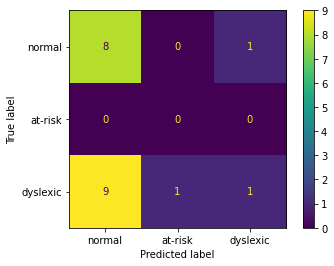

 ari: -0.033  presicion: 0.487  recall:0.450  f1-score: 0.362  auc roc:  0.530  tnr:  0.674 


In [75]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "at-risk", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, ])


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [ ]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))




In [ ]:
shap_values = explainer(x_test)



In [ ]:


print("Shap values are determined!")




In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape




In [ ]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





In [ ]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





In [ ]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




In [ ]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [ ]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


